In [2]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
from scipy.special import gamma
from scipy.special import spherical_jn
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from ipywidgets import widgets, Layout
import os, sys
bold_start = '\033[1m'
bold_end = '\033[0m'

#### Define a function that can write two numpy arrays as a two column ascii file

In [117]:
#writes a two column file taking two numpy arrays 
def write_to_file(x,y,fname):
    if (x.ndim > 1):
        print "Can write only one dimensional x-axis array, The dimension of x-array is ", x.ndim
    elif(y.ndim > 2):
        print "Can write only two dimensional y-axis array, The dimension of y-array is ", y.ndim
    elif (y.ndim == 2 and x.shape[0] ==  y.shape[1]):
        f = open(fname,'w')
        for i in range(x.shape[0]):
            ystr = ''
            for k in range(y.shape[0]):
                ystr = ystr+'\t'+str(y[k,i])
            f.write(str(x[i])+ystr+'\n')
        f.close()
    elif (y.ndim == 1 and  x.shape[0] ==  y.shape[0]):
        f = open(fname,'w')
        for i in range(x.shape[0]):
            f.write(str(x[i])+'\t'+str(y[i])+'\n')
        f.close()
    else:
        print "The arrays have incompatible number of rows with ", x.shape[0], " and ", y.shape[1]
    return

### Defining an unnormalised gaussian function like

$$
G(x,A,\sigma,\mu) = A \frac{1}{\sqrt{2\pi\sigma^2}}\exp\bigg[{-\frac{(x-\mu)^2}{2\sigma^2}}\bigg]
$$

In [4]:
def gaussian_u(x,A,sig,mu):
    return A*(2*np.pi*sig**2)**(-0.5)*np.exp(-(x-mu)**2/(2*sig**2))

### Function to normalise and subtract the data from background
<pre>
Arguments are 
data - numpy array of raw data (in channel number)
bkg - numpy array of respective raw background (in channel number)
flag - 0: get peak centre by fitting an unnormalised gaussian* in the range 350 to 650,
       1: get peak centre by using the maxima in 350 to 650
       2: get peak centre given by the variable given in argument peak
peak - peak value to be taken if flag is set to 2 (otherwise ignored)
</pre>
*<b> Note: The unnormalised Gaussian has a zero baseline, therefore while fitting the scale factor subtracted data and bkg is used (so that the baseline is zero in that region)</b>

In [5]:
def normalise_subtract(data,bkg,flag,peak,ch1,ch2,ch3):
    %matplotlib inline
    font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

    plt.rc('font', **font)    
    
    
    if (not isinstance(flag, int)):
        print "Only integer flag allowed !!!"
        return
    
    #normalising the data and background with a constant
    data_1 = data[ch1:ch2]
    bkg_1 = bkg[ch1:ch2]
    factors = np.divide(bkg_1,data_1)
    
    squares = np.zeros(factors.shape[0])
    for k in range(0,factors.shape[0]):
        squares += (np.multiply(1/factors[k],bkg_1) -  data_1)**2

    squares = squares/squares.shape[0]
    min_pos = np.argmin(squares)
    best_factor = factors[min_pos]
    print min_pos+ch1,data[min_pos+ch1]
    to_sub = data[min_pos+ch1]

    #subtract the background with appropriate peak positions
    #find the peak positions first  
    
##################

    if (flag == 0):
        cno = np.arange(ch2,ch3,1)
        data1 = data - to_sub    
    
        data_peak1 = ch2+np.argmax(data[ch2:ch3])
        
#         lower = [0,10,data_peak1-20]
#         upper = [10000,400,data_peak1+20]
        poptd, pcov = curve_fit(gaussian_u,cno,data1[ch2:ch3],p0=[1000,100,data_peak1])#,bounds=(lower,upper),verbose=2)
        data_peak = poptd[2]
        print "B: ",poptd[-1]
        print poptd
        print bold_start+"Data"+bold_end
        print  "The centre channel from maxima: ",round(data_peak1,5)
        print "The centre channel from the fitting: ",round(data_peak,5)
        print "The difference between the two: ",round(abs(data_peak1-data_peak),5)
        data_peak = int(round(data_peak))    
        
        bkg1 = bkg/best_factor - to_sub
        
        bkg_peak1 = ch2+np.argmax(bkg[ch2:ch3])
#         lower = [0,10,bkg_peak1-20]
#         upper = [10000,400,bkg_peak1+20]
        poptb, pcov = curve_fit(gaussian_u,cno,bkg1[ch2:ch3],p0=[1000,100,bkg_peak1])#,bounds=(lower,upper))
        bkg_peak = poptb[2]
        print "B: ",poptb[-1]
        print poptb
        print bold_start+"Background"+bold_end
        print  "The centre channel from maxima: ",round(bkg_peak1,5)
        print "The centre channel from the fitting: ",round(bkg_peak,5)
        print "The difference between the two: ",round(abs(bkg_peak1-bkg_peak),5)
        bkg_peak = int(round(bkg_peak))
        
        peak_diff = bkg_peak - data_peak
        
    elif (flag == 1):
        bkg_peak = ch2+np.argmax(bkg[ch2:ch3])
        data_peak = ch2+np.argmax(data[ch2:ch3])
        
        peak_diff = bkg_peak - data_peak
        
    else: 
        peak_diff = peak
    
#####################
    
    plt.ylabel("Counts")
    plt.xlabel("Channel") 
    plt.xlim(ch1,ch3)
    ymax = np.amax(data[ch2:ch3])
    ymin = np.amin(data)
    dely = (ymax-ymin)/8.0
    plt.ylim(-10,ymax+dely)
        
    print "The background peak is ahead by : ",peak_diff
    
    if (peak_diff > 0):
        ns_data = data[:-peak_diff] - 1/best_factor*bkg[peak_diff:]
        
        plt.plot(1/factors[min_pos]*bkg[peak_diff:],'x',color='red',label='Background')
        plt.plot(data[:-peak_diff],'x',color='blue',label='Data')
        plt.plot(ns_data,'+',color='green',label='Subtracted Data')
        plt.show()
        
    elif (peak_diff < 0):
        ns_data = data[-peak_diff:] - 1/best_factor*bkg[:peak_diff]
        
        plt.plot(1/factors[min_pos]*bkg[:peak_diff],'x',color='red',label='Background')
        plt.plot(data[-peak_diff:],'x',color='blue',label='Data')
        plt.plot(ns_data,'+',color='green',label='Subtracted Data')
        plt.show()
        
    else:
        ns_data = data - 1/best_factor*bkg 
        
        
        plt.plot(1/factors[min_pos]*bkg,'x',color='red',label='Background')
        plt.plot(data,'x',color='blue',label='Data')
        plt.plot(ns_data,'+',color='green',label='Subtracted Data')
        plt.legend(bbox_to_anchor=(2,1))
        plt.show()
    
#     if (peak_diff == 0):
#         plt.plot(cno,1/factors[min_pos]*bkg1[ch2:ch3],'x',color='cyan',label='Background')
#         plt.plot(cno,1/factors[min_pos]*gaussian_u(cno,*poptb),color='green',label='Background fit')
#         plt.plot(cno,data1[ch2:ch3],'x',label='Data',color='orange')
#         plt.plot(cno,gaussian_u(cno,*poptd),color='red',label='Data fit')
#     else:
#         plt.plot(cno,1/factors[min_pos]*bkg1[ch2:ch3],'x',color='cyan',label='Background')
#         plt.plot(cno,1/factors[min_pos]*gaussian_u(cno,*poptb),color='green',label='Background fit')
#         plt.plot(cno,data1[ch2:ch3],'x',label='Data',color='orange')
#         plt.plot(cno,gaussian_u(cno,*poptd),color='red',label='Data fit')

# #         plt.plot(1/factors[min_pos]*bkg[peak_diff:],label='Background')
#         plt.plot(data[:peak_diff],label='Data')
    #plt.plot(ns_data,label='Subtracted')
    
#    plt.show()

    #display(no)
    #display(no)
    
    #def click_no(b):
     #   ns_data[:] = np.nan
     #   print "The subtracted data has been set NaN"
    #no.on_click(click_no)
    
    
    return ns_data

### Reduce the data - convert into energy axis

In [6]:
#conversion to energy scale
def to_energy(ns,ch1,ch2):
    e0 = 5.11
    theta = 73.69
    twod = 6.67
    con = 81.8
    kbt = 25.8
    cf = 0.04202

    # channel no. for maximum intensity
    mch1 = ch1+np.argmax(ns[ch1:ch2]) #calculate this
    
    #calculate by fitting it with a gaussian_u
    #generate x-axis, by generating channel numbers from 250 to 750
    cno = np.arange(ch1,ch2,1)
    popt, pcov = curve_fit(gaussian_u,cno,ns[ch1:ch2],p0=[1000,100,mch1])
    sig = popt[1]
    print "FWHM in channel numbers from gaussian_u fit: ", round(2.3548*abs(sig),5)
    mu = popt[2]
    print  "The centre channel from maxima: ",round(mch1,5)
    print "The centre channel from the fitting: ",round(mu,5)
    print "The difference between the two: ",round(abs(mch1-mu),5)
    mch = int(round(mu))    
    
    mst = 250 #channel number to start with in conversion

    mchs = mch - mst
    #channel no. to end with in conversion
    med = 2*mch - mst
    #angle in degrees
    theta = theta - (mch - mst)*cf

    print "The starting, centre and ending channels are: ",mst,mch,med
    
    sqw_l = np.zeros((med-mst),dtype='float64')
    energy_l = np.zeros((med-mst),dtype='float64')

    for i in range(0,med-mst):
        theta_r = theta*np.pi/(2.*180.)
        lam = twod*np.sin(theta_r)
        ljac = np.tan(theta_r)/lam

        #energy calculation
        energy_l[i] = con/lam**2 - e0
        #debye-waller factor
        dbf = np.exp(-energy_l[i]/(2*kbt))
        #calculation of S(Q,E)
#         print ns[i+mst],sqw_l[i]
        sqw_l[i] = dbf * ( lam**4. * ljac * ns[i+mst] )/( 8.*con )

        theta = theta + cf

    energy_l = np.flipud(energy_l)
    sqw_l = np.flipud(sqw_l)
    
    
    plt.ylabel("Counts")
    plt.xlabel("Channel") 
    plt.xlim(mu-5*sig,mu+5*sig)
    
    ymax = np.max(ns[ch1:ch2])
    ymin = np.min(ns[ch1:ch2])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    
    plt.ylim(ymin-dely,ymax+dely)
    plt.plot(ns,label='Subtracted')
    plt.axvline(x=mch1,label='From maxima',color='green')
    plt.axvline(x=mch,label='From Fit',color='red')
    cno_cont = np.arange(ch1,ch2,0.01)
    plt.plot(cno_cont,gaussian_u(cno_cont,*popt),label='Fit')
    #print mu,ymax-3*dely
    #plt.text(mu,ymax-3*dely,"$ Q = $"+str(Q[i])+"$ \\AA^{-1}$")
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()
    
    return energy_l,sqw_l

### Read raw data files

Reading file ./QENS0604/QENS06040101.txt for the Q-value 0.67
Reading file ./QENS0601/QENS06010101.txt for the Q-value 0.8
Reading file ./QENS0602/QENS06020101.txt for the Q-value 0.8
Reading file ./QENS0578/QENS05780101.txt for the Q-value 1.08
Reading file ./QENS0579/QENS05790101.txt for the Q-value 1.32
Reading file ./QENS0580/QENS05800101.txt for the Q-value 1.58
Reading file ./QENS0584/QENS05840101.txt for the Q-value 1.58
Reading file ./QENS0609/QENS06090101.txt for the Q-value 1.8


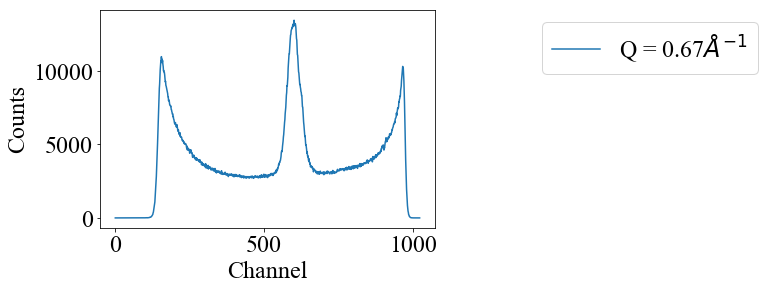

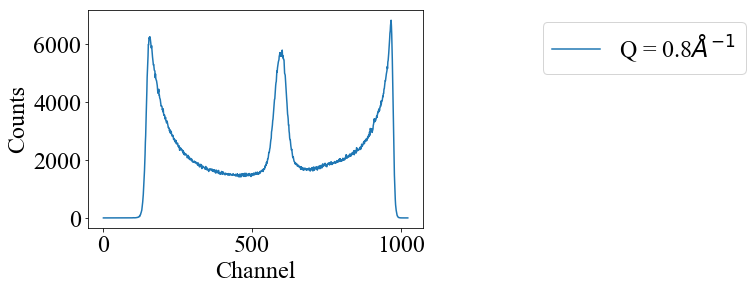

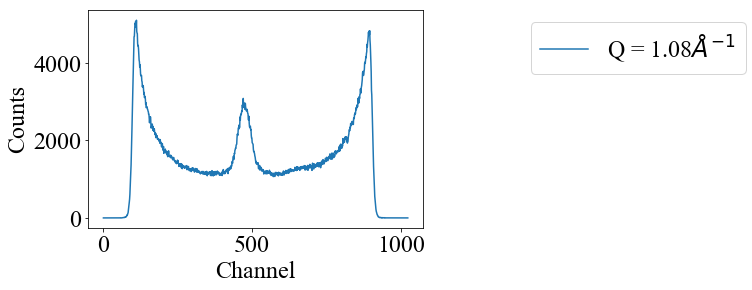

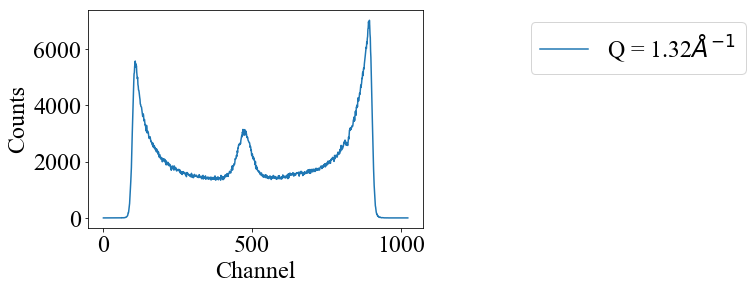

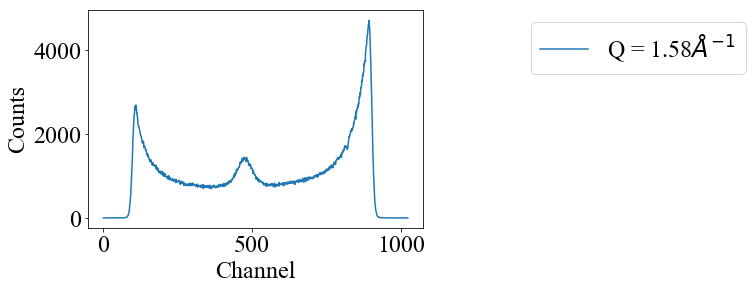

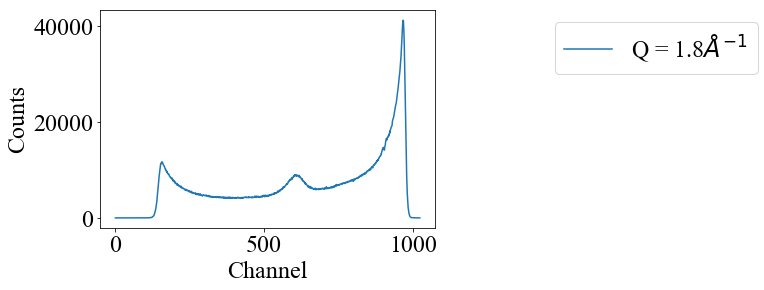

In [7]:
#generate Q-values and filenames
Q = np.array([0.67,0.8,1.08,1.32,1.58,1.8])    #Q-values
nfiles = np.array([1,2,1,1,2,1])      #number of files at each Q-value
#generate file names
index = np.array([604,601,602,578,579,580,584,609]) #indices for filenames, based on number of files for each Q
fprefix = './'
prefix = 'QENS0'
suffix = '0101.txt'
fname = []
for k in range(0,index.shape[0]):
    folder_name = fprefix+prefix+str(index[k])+'/'
    #print folder_name
    fname.append(folder_name+prefix+str(index[k])+suffix)
    #print k,fname[k]

    
#read the raw data file

record_time_data = np.zeros((Q.shape[0]),dtype='float64')
total_counts_data = np.zeros((Q.shape[0]),dtype='float64')
data = np.zeros((Q.shape[0],1024),dtype='float64')
fno = 0

for i in range(0,Q.shape[0]):
    for j in range(0,nfiles[i]):
        #read one file at a time for each individual Q
        data_raw_file = open(fname[fno],'r')
        print "Reading file "+fname[fno]+" for the Q-value "+str(Q[i])
        fno = fno + 1
        lines = data_raw_file.readlines()
        #get the total record time and total event counts
        for line in lines:
            if "Total Time" in line:
                record_time_data[i] = record_time_data[i] + float(line.split()[6])
                total_counts_data[i] = total_counts_data[i] + float(line.split()[12])
        #read from 8th line, leave the first element in split in every line
        k = 0   #channel number
        for line in lines[7:110]:
            for l in range(0,10):
                data[i,k] = data[i,k] + float(line.split()[l+1])
                k+=1
                if (k>1023):
                    break
        data_raw_file.close()
    record_time_data[i] = record_time_data[i]/nfiles[i]
    total_counts_data[i] = total_counts_data[i]/nfiles[i]
    data[i,:] = data[i,:]/nfiles[i]

#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]):
    
    plt.rc('font', **font)
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.plot(data[i],label='Q = '+str(Q[i])+'$\\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

#### If necessray, write raw data to an ascii file (2-col)

In [8]:
cno = np.arange(1,data.shape[1]+1,1)
#use this, if you want to write the counts vs channel number in some files
w = False
if (w):
    folder = 'Raw_data'
    chk = os.path.isdir(folder)
    if (not chk):
        os.mkdir(folder)
    for i in range(0,Q.shape[0]):
        fname = '/Q='+str(Q[i])
        write_to_file(cno,data[i,:],folder+fname)

### Read raw background files corresponding to data

Reading file ./QENS0605/QENS06050101.txt for the Q-value 0.67
Reading file ./QENS0606/QENS06060101.txt for the Q-value 0.8
Reading file ./QENS0607/QENS06070101.txt for the Q-value 0.8
Reading file ./QENS0583/QENS05830101.txt for the Q-value 1.08
Reading file ./QENS0582/QENS05820101.txt for the Q-value 1.32
Reading file ./QENS0581/QENS05810101.txt for the Q-value 1.58
Reading file ./QENS0608/QENS06080101.txt for the Q-value 1.8


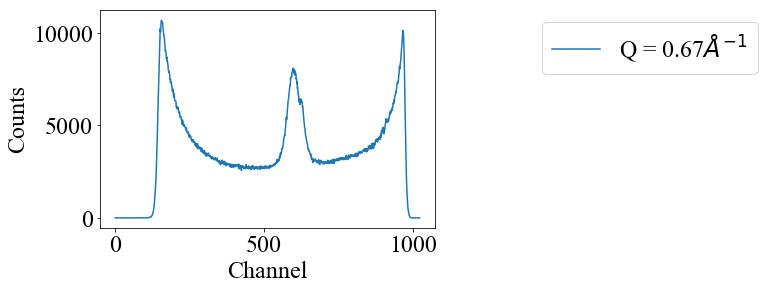

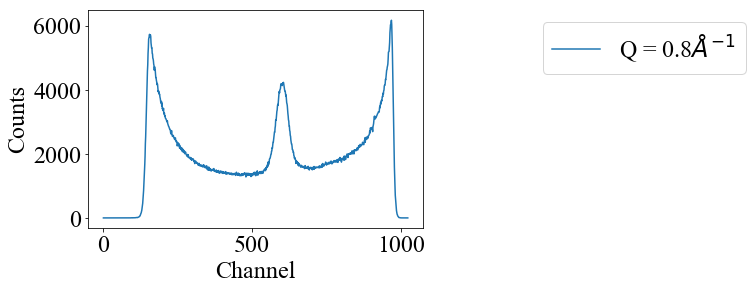

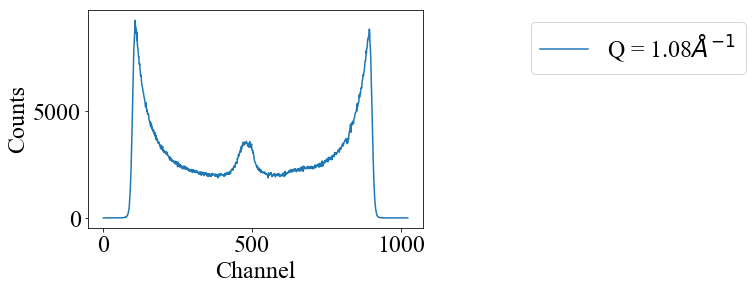

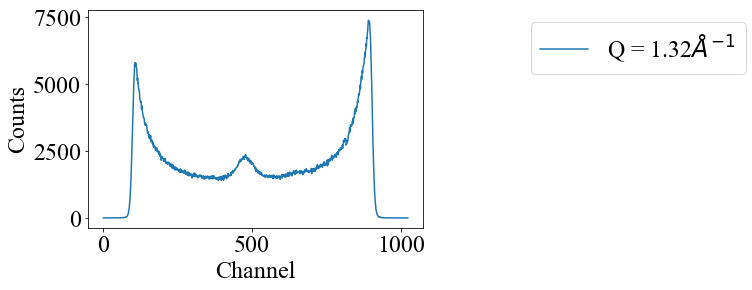

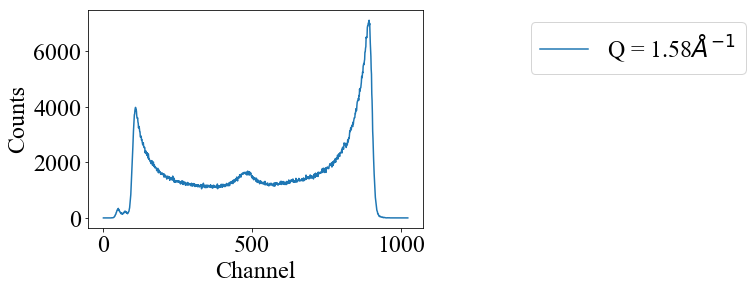

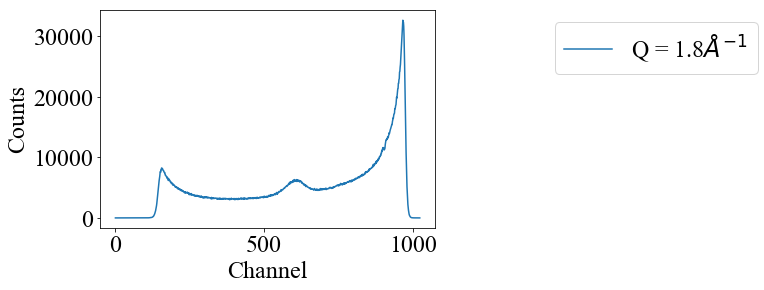

In [9]:
#generate filenames for background
nfiles = np.array([1,2,1,1,1,1])      #number of files at each Q-value
#generate file names
index = np.array([605,606,607,583,582,581,608]) #indices for filenames, based on number of files for each Q
fprefix = './'
prefix = 'QENS0'
suffix = '0101.txt'
fname = []
for k in range(0,index.shape[0]):
    folder_name = fprefix+prefix+str(index[k])+'/'
    #print folder_name
    fname.append(folder_name+prefix+str(index[k])+suffix)
    #print k,fname2[k]
    
#read the raw background file

record_time_bkg = np.zeros((Q.shape[0]),dtype='float64')
total_counts_bkg = np.zeros((Q.shape[0]),dtype='float64')
bkg = np.zeros((Q.shape[0],1024),dtype='float64')
fno = 0

for i in range(0,Q.shape[0]):
    for j in range(0,nfiles[i]):
        #read one file at a time for each individual Q
        bkg_raw_file = open(fname[fno],'r')
        print "Reading file "+fname[fno]+" for the Q-value "+str(Q[i])
        fno = fno + 1
        lines = bkg_raw_file.readlines()
        #get the total record time and total event counts
        for line in lines:
            if "Total Time" in line:
                record_time_bkg[i] = record_time_bkg[i] + float(line.split()[6])
                total_counts_bkg[i] = total_counts_bkg[i] + float(line.split()[12])
        #read from 8th line, leave the first element in split in every line
        k = 0   #channel number
        for line in lines[7:110]:
            for l in range(0,10):
                bkg[i,k] = bkg[i,k] + float(line.split()[l+1])
                k+=1
                if (k>1023):
                    break
        bkg_raw_file.close()
    record_time_bkg[i] = record_time_bkg[i]/nfiles[i]
    total_counts_bkg[i] = total_counts_bkg[i]/nfiles[i]
    bkg[i,:] = bkg[i,:]/nfiles[i]

#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]):
    
    plt.rc('font', **font)
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.plot(bkg[i],label='Q = '+str(Q[i])+'$\\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

#### Write the raw data file if required!

In [10]:
cno = np.arange(1,data.shape[1]+1,1)
#use this, if you want to write the counts vs channel number in some files
w = False
if (w):
    folder = 'Raw_bkg'
    chk = os.path.isdir(folder)
    if (not chk):
        os.mkdir(folder)
    for i in range(0,Q.shape[0]):
        fname = '/Q='+str(Q[i])
        write_to_file(cno,bkg[i,:],folder+fname)

### Normalise and background subtract data

_________________________________________________________________ Q = 0.67
347 3135.0
B:  599.9960335935288
[5.39082311e+05 2.12953912e+01 5.99996034e+02]
Data
The centre channel from maxima:  601.0
The centre channel from the fitting:  599.99603
The difference between the two:  1.00397
B:  602.8354993384172
[ 2.82595336e+05 -2.28165744e+01  6.02835499e+02]
Background
The centre channel from maxima:  597.0
The centre channel from the fitting:  602.8355
The difference between the two:  5.8355
The background peak is ahead by :  3


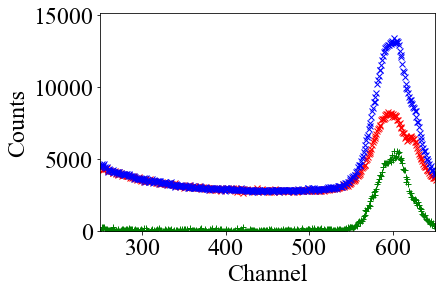

_________________________________________________________________ Q = 0.8
342 1712.5
B:  595.8445773779066
[ 1.98095979e+05 -1.93486449e+01  5.95844577e+02]
Data
The centre channel from maxima:  601.0
The centre channel from the fitting:  595.84458
The difference between the two:  5.15542
B:  601.3469638077639
[ 1.41574085e+05 -1.95682361e+01  6.01346964e+02]
Background
The centre channel from maxima:  605.0
The centre channel from the fitting:  601.34696
The difference between the two:  3.65304
The background peak is ahead by :  5


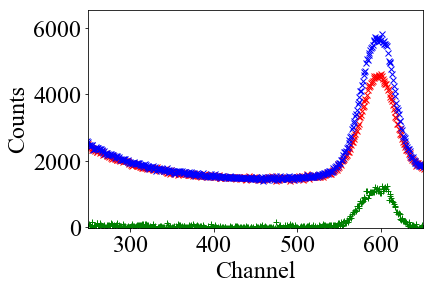

_________________________________________________________________ Q = 1.08
328 1163.0
The background peak is ahead by :  11


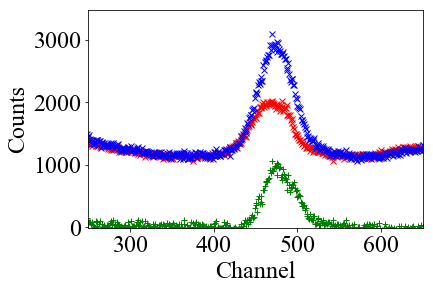

_________________________________________________________________ Q = 1.32
331 1387.0
B:  474.39101171396527
[ 9.69838830e+04 -2.40735014e+01  4.74391012e+02]
Data
The centre channel from maxima:  469.0
The centre channel from the fitting:  474.39101
The difference between the two:  5.39101
B:  477.7943170658492
[5.02491744e+04 2.78174674e+01 4.77794317e+02]
Background
The centre channel from maxima:  478.0
The centre channel from the fitting:  477.79432
The difference between the two:  0.20568
The background peak is ahead by :  4


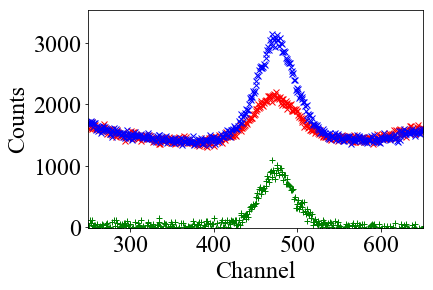

_________________________________________________________________ Q = 1.58
325 739.0
B:  475.4175782330667
[4.49211729e+04 2.74502859e+01 4.75417578e+02]
Data
The centre channel from maxima:  481.0
The centre channel from the fitting:  475.41758
The difference between the two:  5.58242
B:  480.52826967880577
[25624.12758306   -33.38637004   480.52826968]
Background
The centre channel from maxima:  485.0
The centre channel from the fitting:  480.52827
The difference between the two:  4.47173
The background peak is ahead by :  6


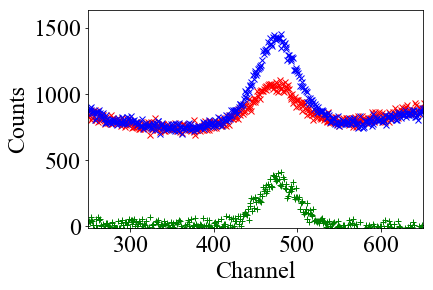

_________________________________________________________________ Q = 1.8
332 4406.0
B:  607.7133122254355
[3.77090442e+05 3.49699721e+01 6.07713312e+02]
Data
The centre channel from maxima:  604.0
The centre channel from the fitting:  607.71331
The difference between the two:  3.71331
B:  608.5831121438696
[4.19765666e+05 4.23883319e+01 6.08583112e+02]
Background
The centre channel from maxima:  602.0
The centre channel from the fitting:  608.58311
The difference between the two:  6.58311
The background peak is ahead by :  1


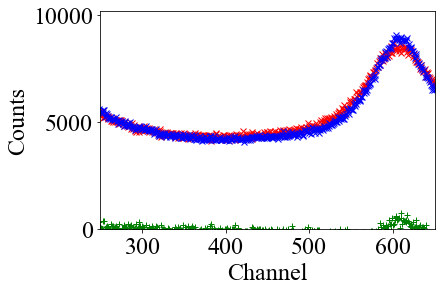

In [11]:
ns = []

flg  = np.array([0,0,1,0,0,0])
peak = np.array([0,0,0,0,0,0])

c1 = 250
c2 = 350
c3 = 650

for i in range(0,Q.shape[0]):
    print "_________________________________________________________________ Q =",Q[i]
    ns.append(normalise_subtract(data[i,:],bkg[i,:],flg[i],peak[i],c1,c2,c3))

### Convert into energy axis using the function defined above

Data reduction for the Q-value : 0.67
FWHM in channel numbers from gaussian_u fit:  46.18532
The centre channel from maxima:  601.0
The centre channel from the fitting:  600.26813
The difference between the two:  0.73187
The starting, centre and ending channels are:  250 600 950


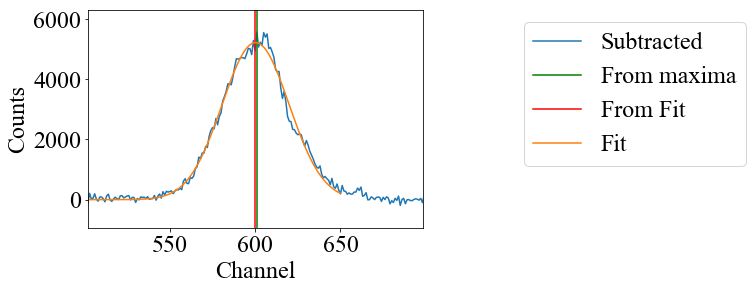

Data reduction for the Q-value : 0.8
FWHM in channel numbers from gaussian_u fit:  44.41626
The centre channel from maxima:  607.0
The centre channel from the fitting:  594.69428
The difference between the two:  12.30572
The starting, centre and ending channels are:  250 595 940


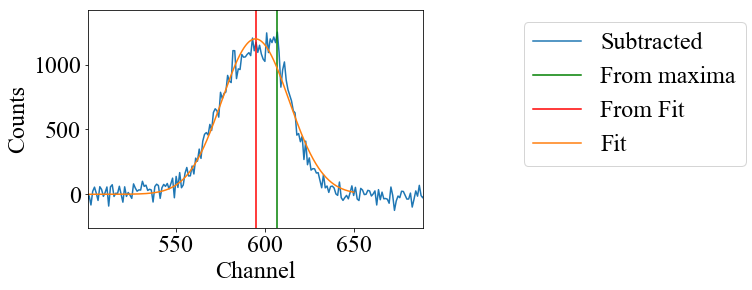

Data reduction for the Q-value : 1.08
FWHM in channel numbers from gaussian_u fit:  45.16002
The centre channel from maxima:  470.0
The centre channel from the fitting:  478.30166
The difference between the two:  8.30166
The starting, centre and ending channels are:  250 478 706


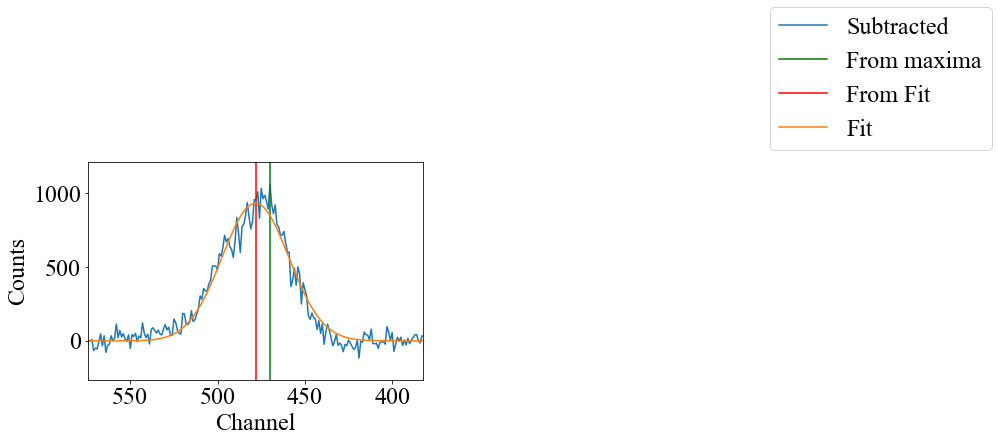

Data reduction for the Q-value : 1.32
FWHM in channel numbers from gaussian_u fit:  49.49247
The centre channel from maxima:  469.0
The centre channel from the fitting:  474.9625
The difference between the two:  5.9625
The starting, centre and ending channels are:  250 475 700


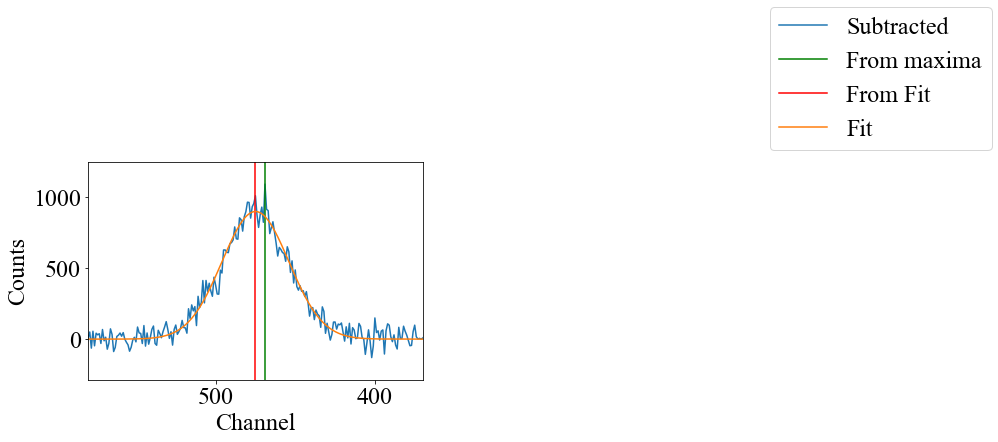

Data reduction for the Q-value : 1.58
FWHM in channel numbers from gaussian_u fit:  55.26359
The centre channel from maxima:  481.0
The centre channel from the fitting:  476.59891
The difference between the two:  4.40109
The starting, centre and ending channels are:  250 477 704


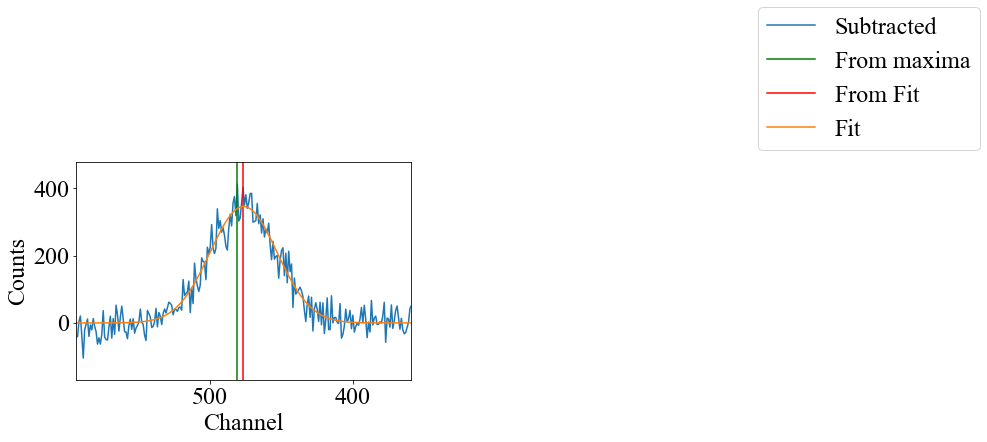

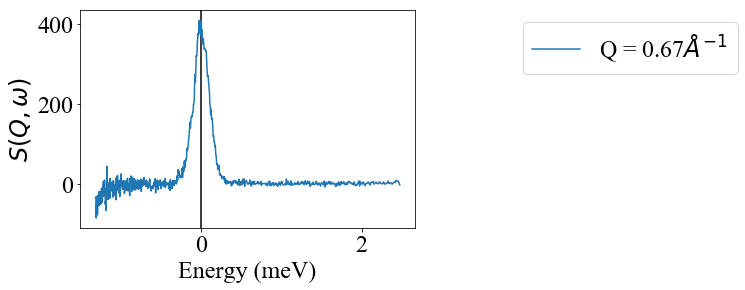

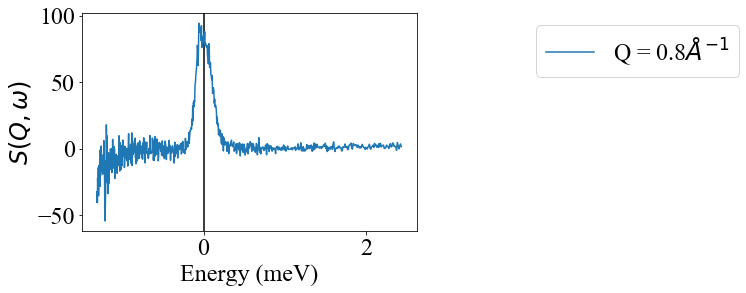

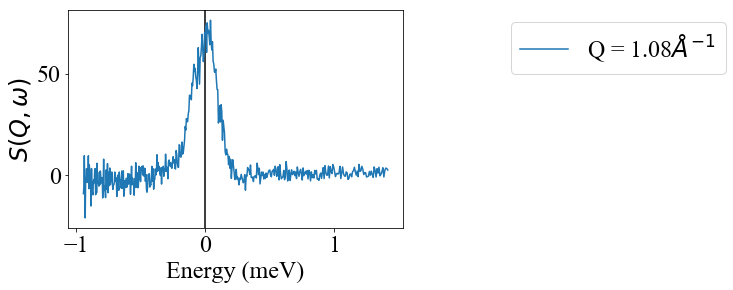

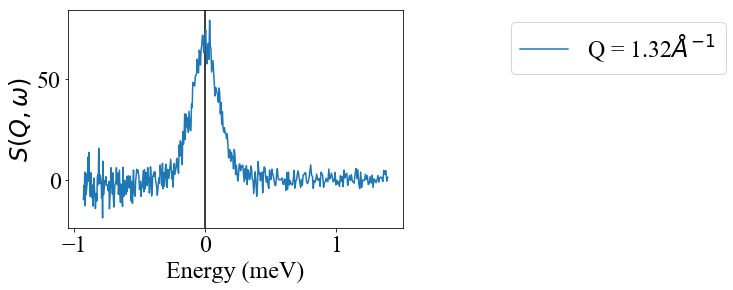

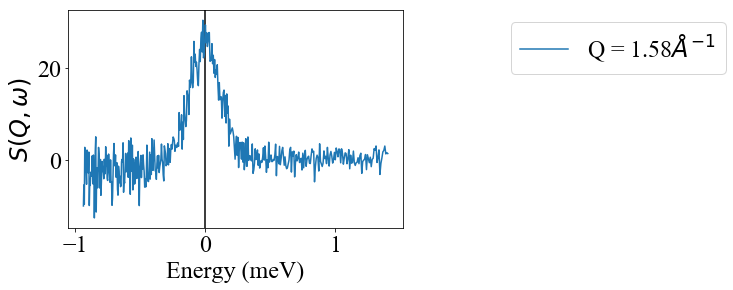

In [12]:
en = []
sqw_tmp = []
for i in range(0,Q.shape[0]-1):
    print bold_start+"Data reduction for the Q-value : "+str(Q[i])+bold_end
    
    tmp = to_energy(ns[i],c2,c3)
    en.append(tmp[0])
    sqw_tmp.append(tmp[1])

#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]-1):
    
    plt.rc('font', **font)
    plt.xlabel('Energy (meV)')
    plt.ylabel('$S(Q,\omega)$')
    plt.axvline(x=0,color='black')
    plt.plot(en[i],sqw_tmp[i],label='Q = '+str(Q[i])+'$\\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

### Rebin data at 0.02 meV in range -1 to +1 meV

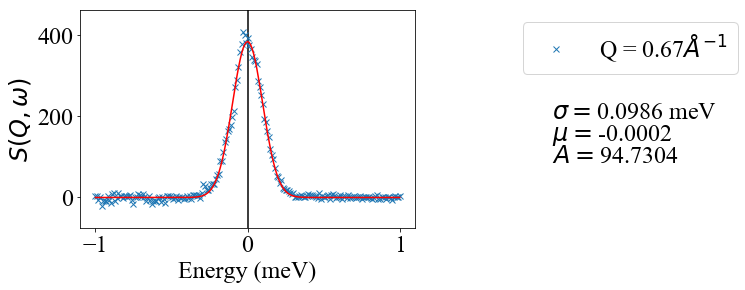

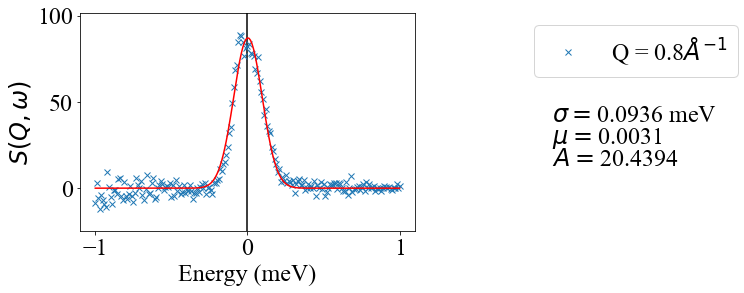

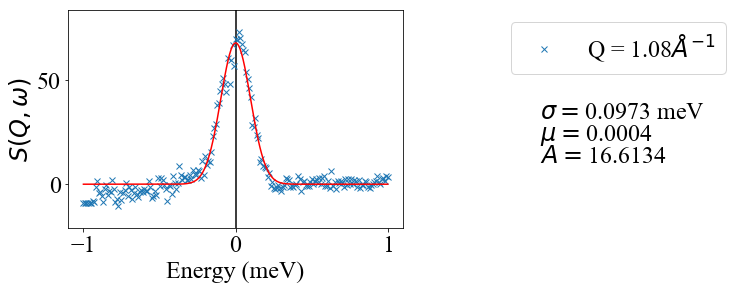

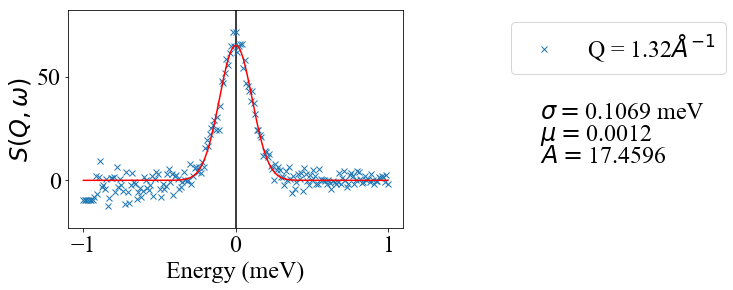

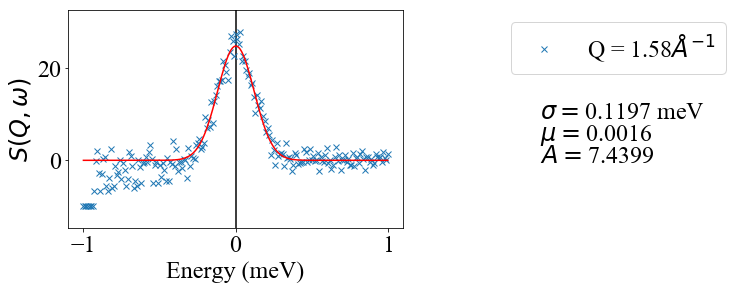

In [13]:
#rebinning data at an interval 0.02
delE = 0.01
energy = np.arange(-1.0,1.0+delE,delE)
sqw = np.zeros((Q.shape[0],energy.shape[0]),dtype='float64')
for i in range(0,Q.shape[0]-1):
    sqw[i,:] = np.interp(energy,en[i],sqw_tmp[i])

    
#getting width of data with respect to Q, huerestically with a gaussian_u

widths = np.zeros((Q.shape[0]-1),dtype='float64')


    
#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]-1):
    
    ymax = np.max(sqw[i,:])
    ymin = np.min(sqw[i,:])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    
    #just fitting all the curves with a gaussian_u to see how it fares
    popt, pcov = curve_fit(gaussian_u,energy,sqw[i,:])
    
    mu = popt[2]
    sig = abs(popt[1])
    widths[i] = sig
    A = popt[0]
    
    plt.ylim(ymin-dely,ymax+dely)
    
    plt.rc('font', **font)
    plt.xlabel('Energy (meV)')
    plt.ylabel('$S(Q,\omega)$')
    plt.axvline(x=0,color='black')
    plt.plot(energy,sqw[i,:],'x',label='Q = '+str(Q[i])+'$ \\AA^{-1}$')
    plt.plot(energy,gaussian_u(energy,*popt),color='red')
    plt.text(+2,ymax-4*dely,"$\sigma = $"+str(round(sig,4))+' meV')
    plt.text(+2,ymax-5*dely,"$\mu = $"+str(round(mu,4)))
    plt.text(+2,ymax-6*dely,"$ A = $"+str(round(A,4)))
    
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

### Plotting the widths from the Gaussian with respect Q 

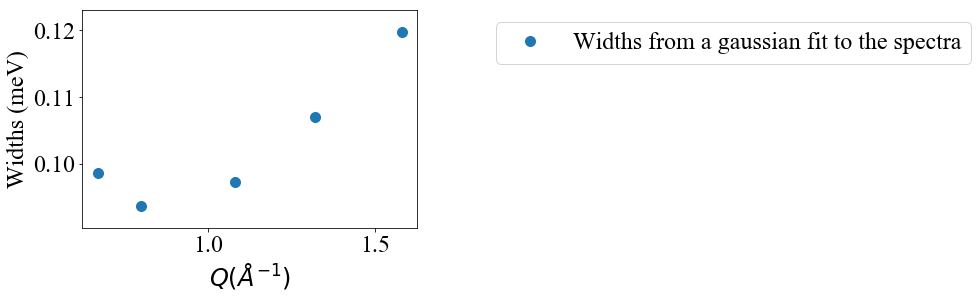

In [14]:
#plotting the widths with respect Q, to see how it is in general

ymax = np.max(widths)
ymin = np.min(widths)
ydiff = (ymax - ymin)
dely = ydiff/8

plt.ylim(ymin-dely,ymax+dely)

plt.xlabel("$Q (\\AA^{-1})$")
plt.ylabel("Widths (meV)")
plt.plot(Q[:-1],widths,'o',ms=10,label='Widths from a gaussian fit to the spectra')
plt.legend(bbox_to_anchor=(1.2,1))

### Mirror the data by zero energy transfer

In [15]:
sqw.shape, energy.shape

((6, 201), (201,))

### Reading the raw data file for resolution

Reading file QENS0597/QENS05970101.txt for the Q-value 0.67
Reading file QENS0597/QENS05970101.txt for the Q-value 0.8
Reading file QENS0597/QENS05970101.txt for the Q-value 1.08
Reading file QENS0597/QENS05970101.txt for the Q-value 1.32
Reading file QENS0597/QENS05970101.txt for the Q-value 1.58
Reading file QENS0597/QENS05970101.txt for the Q-value 1.8


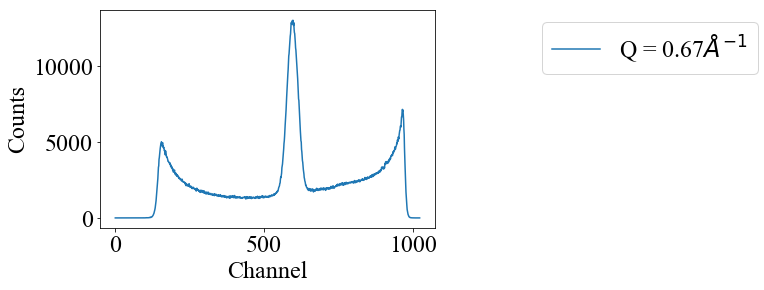

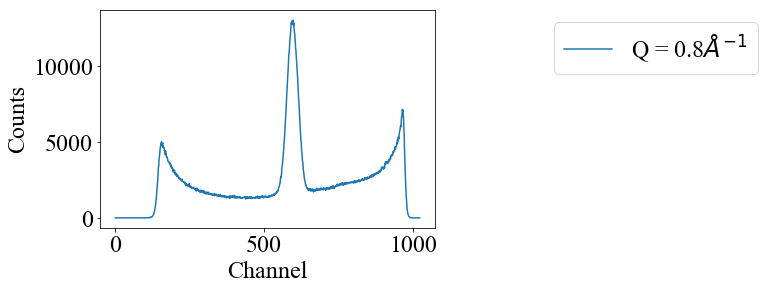

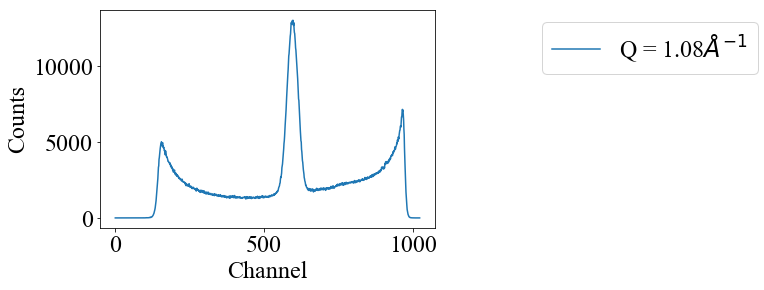

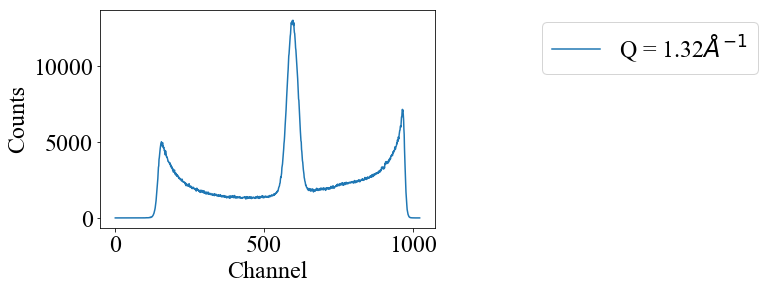

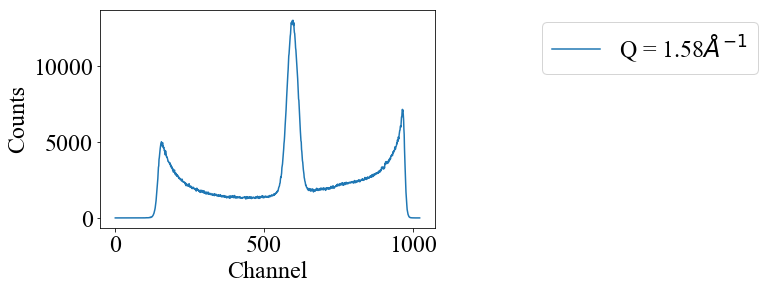

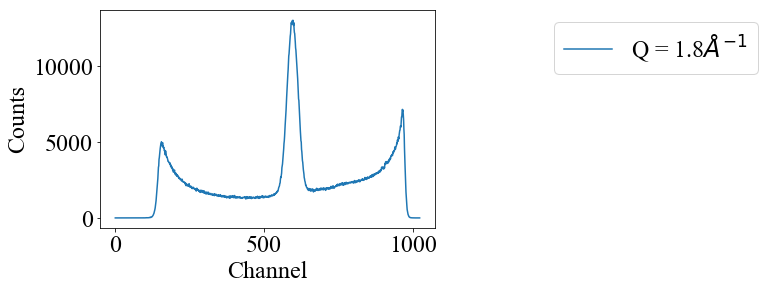

In [16]:
#generate filenames for background
nfiles = np.array([1,1,1,1,1,1])      #number of files at each Q-value
#generate file names
index = np.array([597,597,597,597,597,597]) #indices for filenames, based on number of files for each Q
fprefix = ''
prefix = 'QENS0'
suffix = '0101.txt'
fname = []
for k in range(0,index.shape[0]):
    folder_name = fprefix+prefix+str(index[k])+'/'
    #print folder_name
    fname.append(folder_name+prefix+str(index[k])+suffix)
    #print k,fname2[k]
    
#read the raw background file

record_time_res = np.zeros((Q.shape[0]),dtype='float64')
total_counts_res = np.zeros((Q.shape[0]),dtype='float64')
res = np.zeros((Q.shape[0],1024),dtype='float64')
fno = 0

for i in range(0,Q.shape[0]):
    for j in range(0,nfiles[i]):
        #read one file at a time for each individual Q
        res_raw_file = open(fname[fno],'r')
        print "Reading file "+fname[fno]+" for the Q-value "+str(Q[i])
        fno = fno + 1
        lines = res_raw_file.readlines()
        #get the total record time and total event counts
        for line in lines:
            if "Total Time" in line:
                record_time_res[i] = record_time_res[i] + float(line.split()[6])
                total_counts_res[i] = total_counts_res[i] + float(line.split()[12])
        #read from 8th line, leave the first element in split in every line
        k = 0   #channel number
        for line in lines[7:110]:
            for l in range(0,10):
                res[i,k] = res[i,k] + float(line.split()[l+1])
                k+=1
                if (k>1023):
                    break
        res_raw_file.close()
    record_time_res[i] = record_time_res[i]/nfiles[i]
    total_counts_res[i] = total_counts_res[i]/nfiles[i]
    res[i,:] = res[i,:]/nfiles[i]

#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]):
    
    plt.rc('font', **font)
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.plot(res[i],label='Q = '+str(Q[i])+'$\\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

### Reading raw background file for associated resolution file

Reading file QENS0598/QENS05980101.txt for the Q-value 0.67
Reading file QENS0598/QENS05980101.txt for the Q-value 0.8
Reading file QENS0598/QENS05980101.txt for the Q-value 1.08
Reading file QENS0598/QENS05980101.txt for the Q-value 1.32
Reading file QENS0598/QENS05980101.txt for the Q-value 1.58
Reading file QENS0598/QENS05980101.txt for the Q-value 1.8


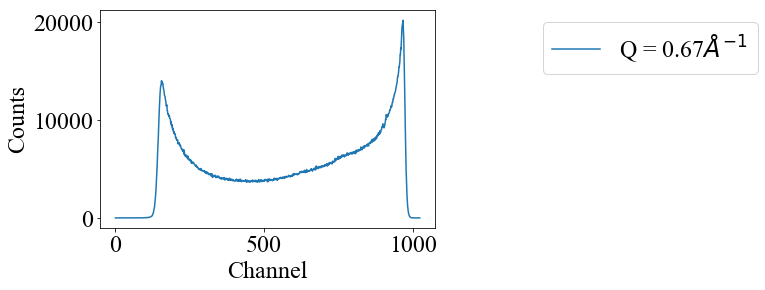

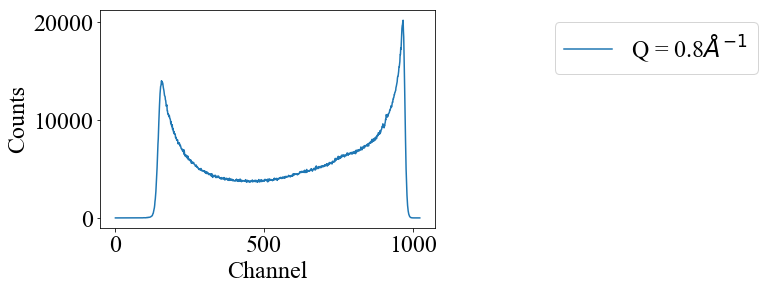

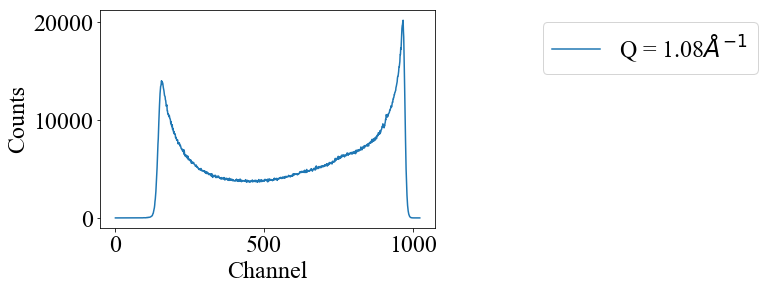

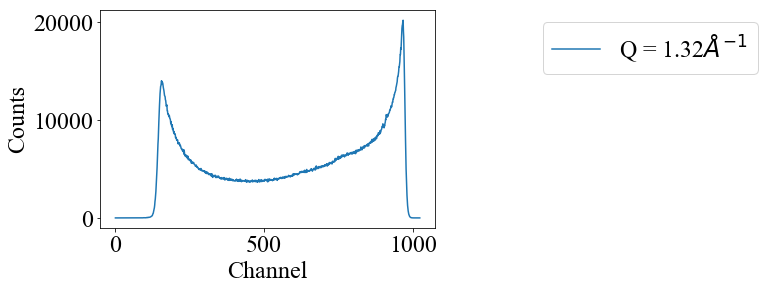

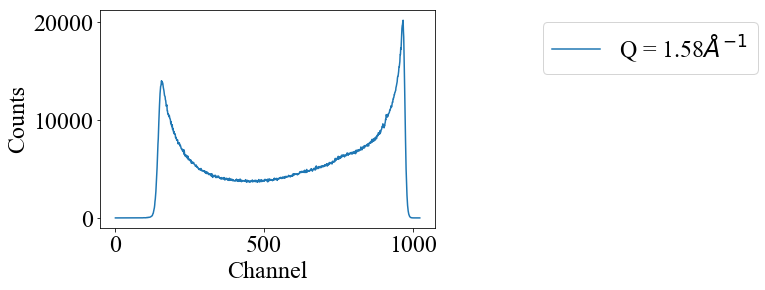

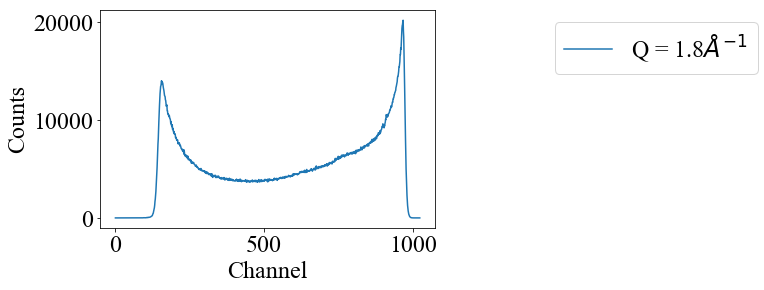

In [17]:
#generate filenames for background
nfiles = np.array([1,1,1,1,1,1])      #number of files at each Q-value
#generate file names
index = np.array([598,598,598,598,598,598]) #indices for filenames, based on number of files for each Q
fprefix = ''
prefix = 'QENS0'
suffix = '0101.txt'
fname = []
for k in range(0,index.shape[0]):
    folder_name = fprefix+prefix+str(index[k])+'/'
    #print folder_name
    fname.append(folder_name+prefix+str(index[k])+suffix)
    #print k,fname2[k]
    
#read the raw background file

record_time_res_bkg = np.zeros((Q.shape[0]),dtype='float64')
total_counts_res_bkg = np.zeros((Q.shape[0]),dtype='float64')
res_bkg = np.zeros((Q.shape[0],1024),dtype='float64')
fno = 0

for i in range(0,Q.shape[0]):
    for j in range(0,nfiles[i]):
        #read one file at a time for each individual Q
        res_bkg_raw_file = open(fname[fno],'r')
        print "Reading file "+fname[fno]+" for the Q-value "+str(Q[i])
        fno = fno + 1
        lines = res_bkg_raw_file.readlines()
        #get the total record time and total event counts
        for line in lines:
            if "Total Time" in line:
                record_time_res_bkg[i] = record_time_res_bkg[i] + float(line.split()[6])
                total_counts_res_bkg[i] = total_counts_res_bkg[i] + float(line.split()[12])
        #read from 8th line, leave the first element in split in every line
        k = 0   #channel number
        for line in lines[7:110]:
            for l in range(0,10):
                res_bkg[i,k] = res_bkg[i,k] + float(line.split()[l+1])
                k+=1
                if (k>1023):
                    break
        res_bkg_raw_file.close()
    record_time_res_bkg[i] = record_time_res_bkg[i]/nfiles[i]
    total_counts_res_bkg[i] = total_counts_res_bkg[i]/nfiles[i]
    res_bkg[i,:] = res_bkg[i,:]/nfiles[i]

#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]):
    
    plt.rc('font', **font)
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.plot(res_bkg[i],label='Q = '+str(Q[i])+'$\\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

#### Normalising with the background and subtracting the background from resolution

597
303
597
303
349 1467.0
The background peak is ahead by :  0


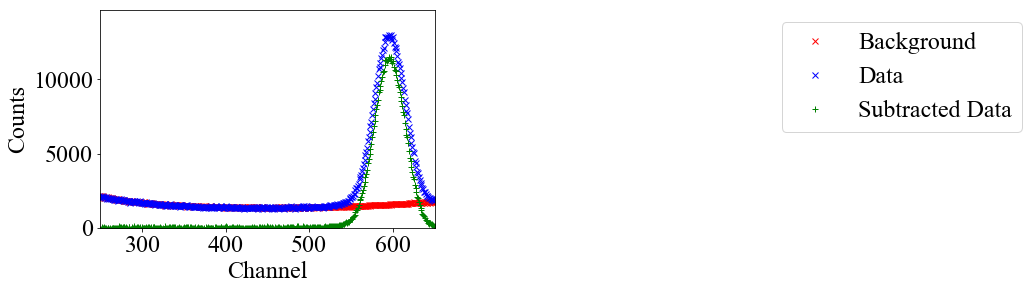

349 1467.0
The background peak is ahead by :  0


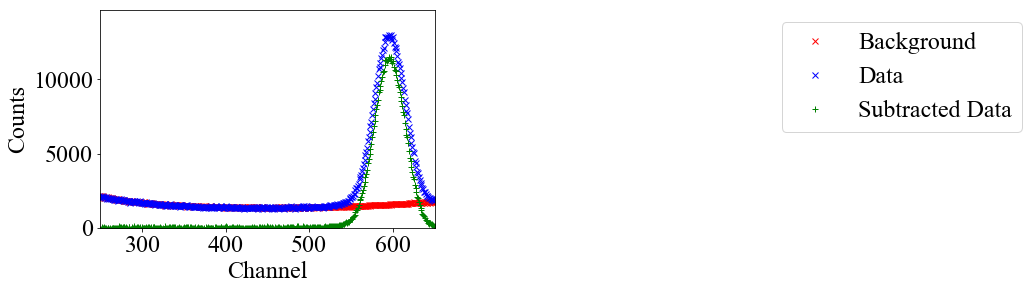

349 1467.0
The background peak is ahead by :  0


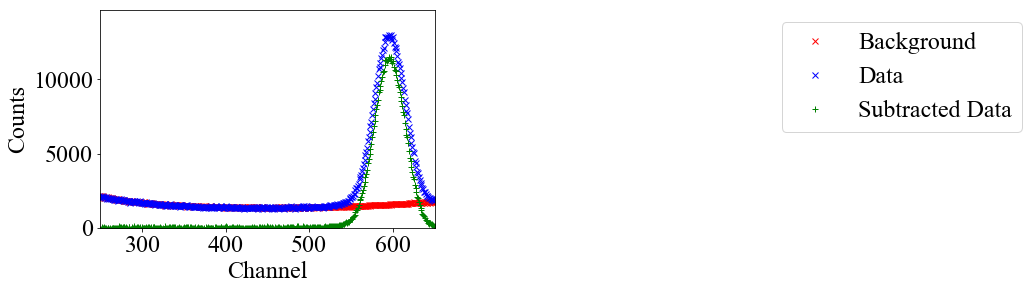

349 1467.0
The background peak is ahead by :  0


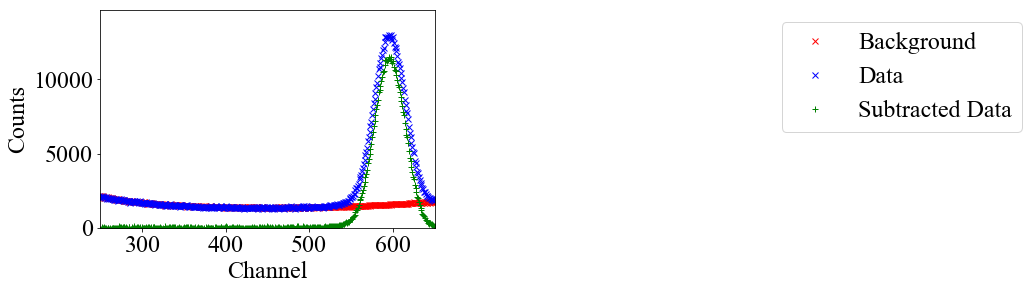

349 1467.0
The background peak is ahead by :  0


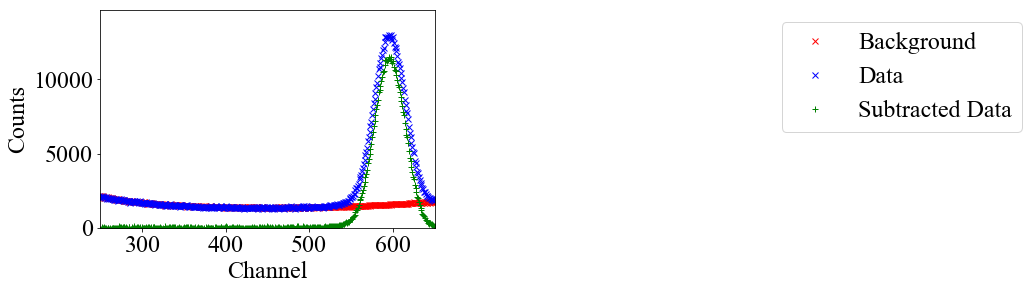

349 1467.0
The background peak is ahead by :  0


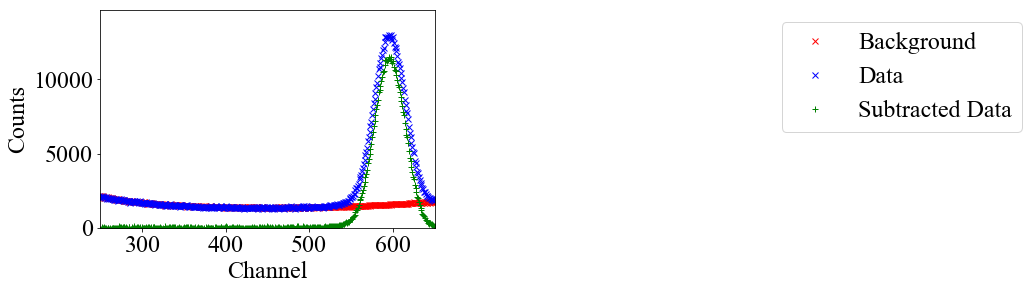

In [18]:
##just checking :-D
print 300+np.argmax(res[0,300:600])
print 300+np.argmax(res_bkg[0,300:600])
print 300+np.argmax(res[1,300:600])
print 300+np.argmax(res_bkg[1,300:600])

ns_res = []

flgs = np.zeros((Q.shape[0]),dtype='int')
flgs.fill(2)
peaks = np.zeros((Q.shape[0]),dtype='int')
# peaks[1] = 7
for i in range(0,Q.shape[0]):
    ns_res.append(normalise_subtract(res[i,:],res_bkg[i,:],flgs[i],peaks[i],c1,c2,c3))

#### Converting into energy scale

Data reduction for the Q-value : 0.67
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


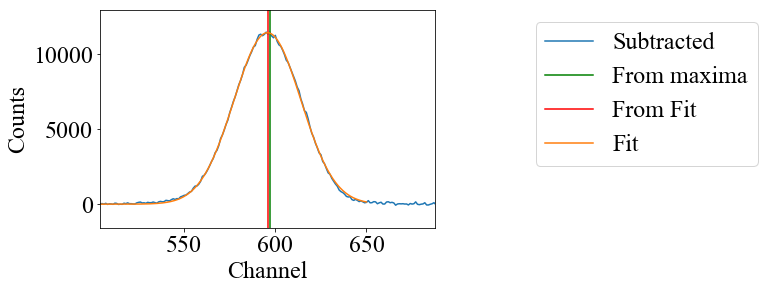

Data reduction for the Q-value : 0.8
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


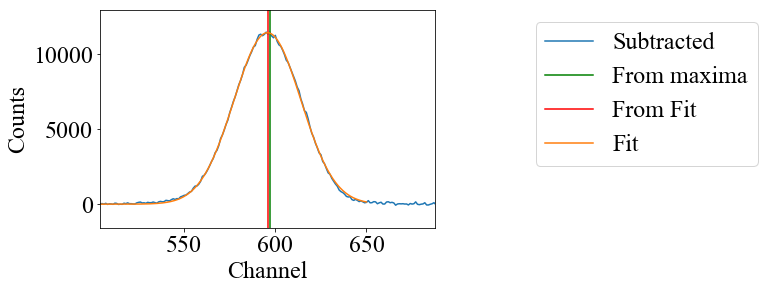

Data reduction for the Q-value : 1.08
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


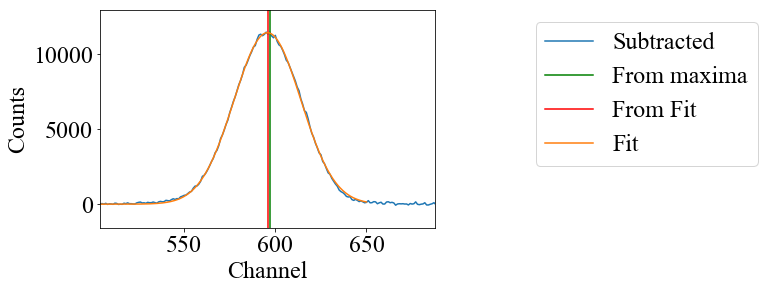

Data reduction for the Q-value : 1.32
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


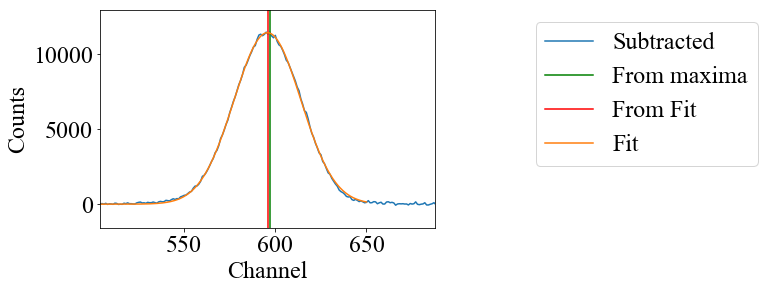

Data reduction for the Q-value : 1.58
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


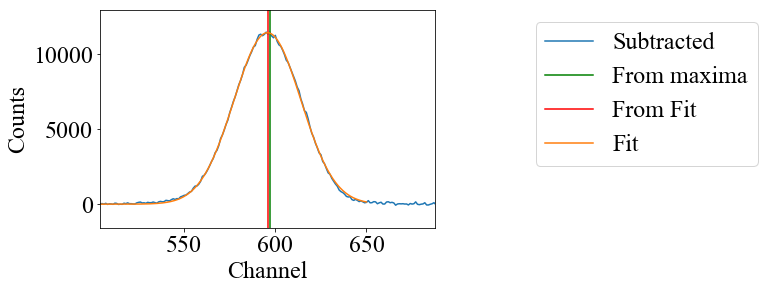

Data reduction for the Q-value : 1.8
FWHM in channel numbers from gaussian_u fit:  43.24554
The centre channel from maxima:  597.0
The centre channel from the fitting:  595.69907
The difference between the two:  1.30093
The starting, centre and ending channels are:  250 596 942


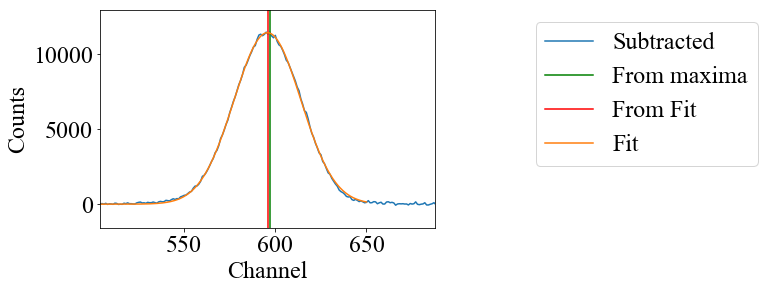

In [19]:
en_res = []
sqw_res_tmp = []
for i in range(0,Q.shape[0]):
    print bold_start+"Data reduction for the Q-value : "+str(Q[i])+bold_end
    
    tmp = to_energy(ns_res[i],c2,c3)
    en_res.append(tmp[0])
    sqw_res_tmp.append(tmp[1])

#### Rebinning the resolution data between -1 to 1 with 0.02 bin size

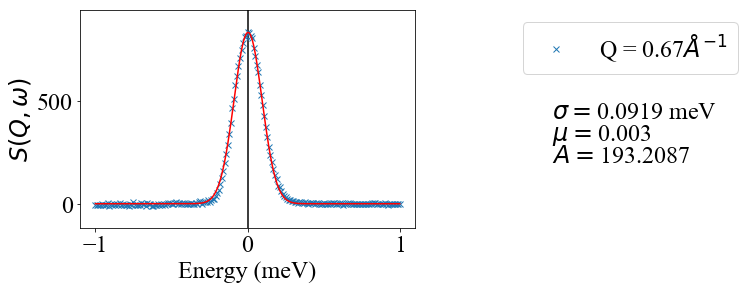

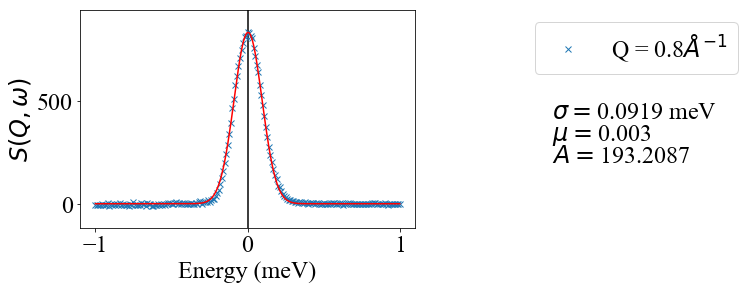

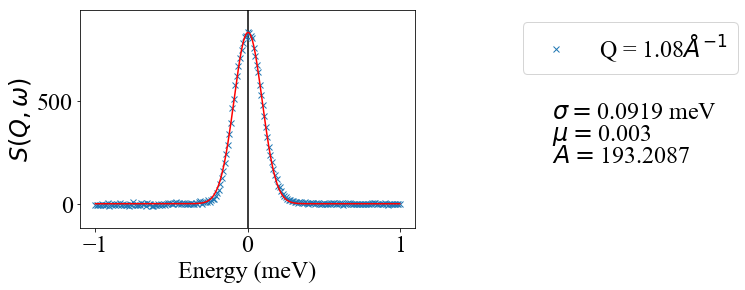

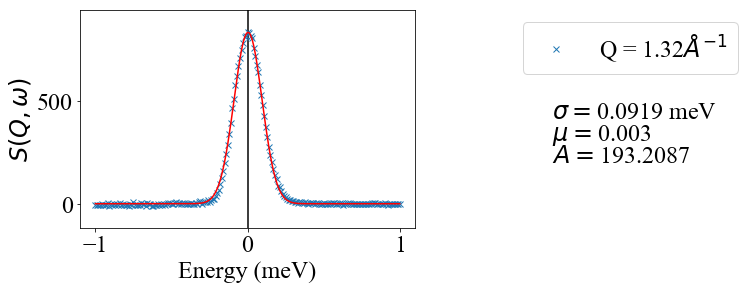

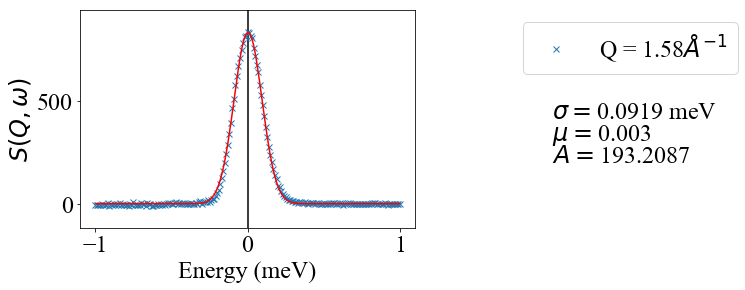

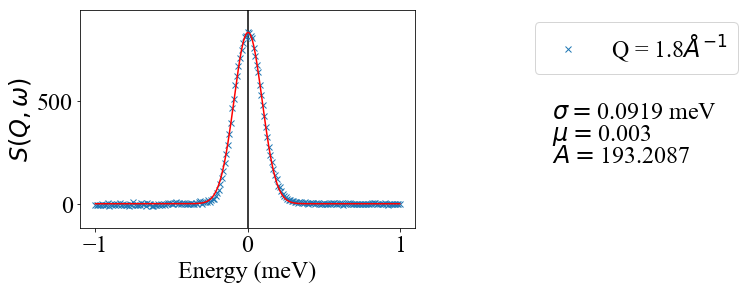

In [20]:
#rebinning data at an interval 0.02

sqw_res = np.zeros((Q.shape[0],energy.shape[0]),dtype='float64')
for i in range(0,Q.shape[0]):
    sqw_res[i,:] = np.interp(energy,en_res[i],sqw_res_tmp[i])

    
#getting width of data with respect to Q, huerestically with a gaussian_u

widths_res = np.zeros((Q.shape[0]),dtype='float64')
widths_res_err = np.zeros((Q.shape[0]),dtype='float64')


    
#plotting the data at all Q-values
font = {'family' : 'times new roman',
        'weight' : 'normal',
        'size'   : 24}

for i in range(0,Q.shape[0]):
    
    ymax = np.max(sqw_res[i,:])
    ymin = np.min(sqw_res[i,:])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    
    #just fitting all the curves with a gaussian_u to see how it fares
    popt, pcov = curve_fit(gaussian_u,energy,sqw_res[i,:])
    
    mu = popt[2]
    sig = abs(popt[1])
    widths_res[i] = sig
    widths_res_err[i] = np.sqrt(pcov[1,1])
    A = popt[0]
    
    plt.ylim(ymin-dely,ymax+dely)
    
    plt.rc('font', **font)
    plt.xlabel('Energy (meV)')
    plt.ylabel('$S(Q,\omega)$')
    plt.axvline(x=0,color='black')
    plt.plot(energy,sqw_res[i,:],'x',label='Q = '+str(Q[i])+'$ \\AA^{-1}$')
    plt.plot(energy,gaussian_u(energy,*popt),color='red')
    plt.text(+2,ymax-4*dely,"$\sigma = $"+str(round(sig,4))+' meV')
    plt.text(+2,ymax-5*dely,"$\mu = $"+str(round(mu,4)))
    plt.text(+2,ymax-6*dely,"$ A = $"+str(round(A,4)))
    
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

The average sigma of the resolution function: 0.09193 meV
Correspondingly the FWHM is : 0.21648 meV


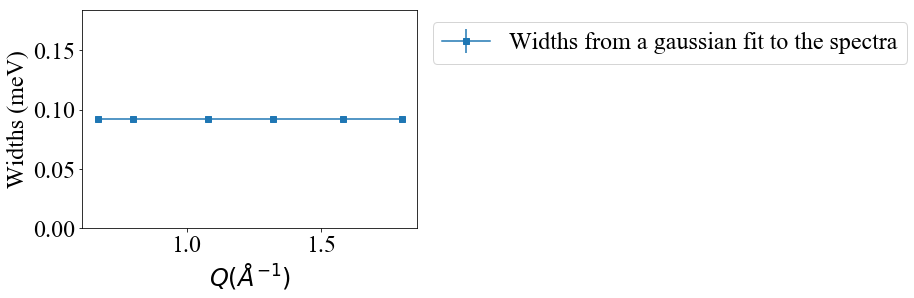

In [21]:
#plotting the widths with respect Q, to see how it is in general

ymax = np.max(widths_res)
ymin = np.min(widths_res)
ydiff = (ymax - ymin)
dely = ydiff/8

plt.ylim(0,2*ymax)

plt.xlabel("$Q (\\AA^{-1})$")
plt.ylabel("Widths (meV)")
plt.errorbar(Q,widths_res,widths_res_err,marker='s',
             label='Widths from a gaussian fit to the spectra')
plt.legend(bbox_to_anchor=(2.5,1))

print "The average sigma of the resolution function: "+bold_start+str(round(np.average(widths_res),5))+bold_end+" meV"
print "Correspondingly the FWHM is : "+bold_start+str(round(2.3548*np.average(widths_res),5))+bold_end+" meV"


#setting sigma of the resolution as np array
sig_res = widths_res
sig_res_avg = np.average(widths_res)

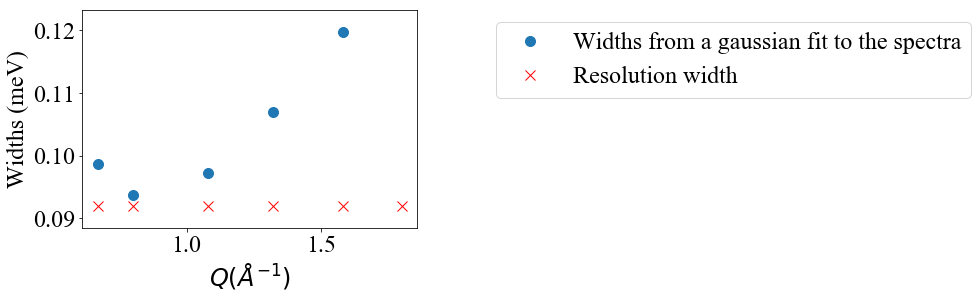

In [22]:
#plotting the resolution width along with the others

ymax = np.max(widths)
ymin = np.min(widths_res)
ydiff = (ymax - ymin)
dely = ydiff/8

plt.ylim(ymin-dely,ymax+dely)

plt.xlabel("$Q (\\AA^{-1})$")
plt.ylabel("Widths (meV)")
plt.plot(Q[:-1],widths,'o',ms=10,label='Widths from a gaussian fit to the spectra')
plt.plot(Q,sig_res,'x',ms=10,color='red',label='Resolution width')
plt.legend(bbox_to_anchor=(1.2,1))

### Area normalising all the data and resolution - to use it for convolution

In [23]:
#area normalise all spectra
area = np.zeros((Q.shape[0]),dtype='float64')
area_res = np.zeros((Q.shape[0]),dtype='float64')
sqw_normalised = np.zeros((sqw.shape),dtype='float64')
sqw_res_normalised = np.zeros((sqw.shape),dtype='float64')

print " Area of Data"
for i in range(0,Q.shape[0]-1):
    area[i] = np.trapz(energy,sqw[i])
    print abs(area[i])
    sqw_normalised[i] = sqw[i]/abs(area[i])
print "\n Area of Resolution"
for i in range(0,Q.shape[0]-1):
    area_res[i] = np.trapz(energy,sqw_res[i])
    print abs(area_res[i])
    sqw_res_normalised[i] = sqw_res[i]/abs(area_res[i])


 Area of Data
89.50739288126988
27.089782561306702
20.711735641518807
27.803695754950205
14.320520204260522

 Area of Resolution
197.9280407506259
197.9280407506259
197.9280407506259
197.9280407506259
197.9280407506259


### Defining a normalised gaussian of the form

$$
G(x,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\bigg[{-\frac{x^2}{2\sigma^2}}\bigg]
$$

### Fitting all the resolution with the above Gaussian to get the $\sigma$

[0.09340911] [[9.75731915e-08]] 0.09193130005837381 0.00025980787211924144


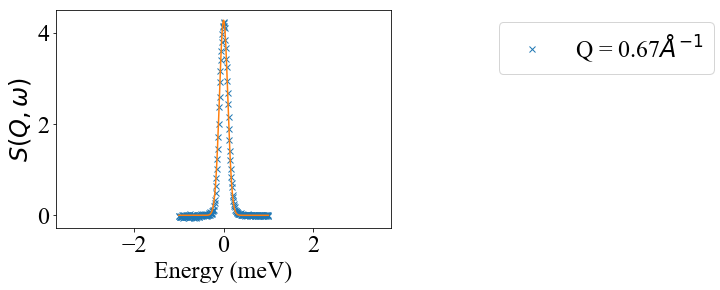

[0.09340911] [[9.75731915e-08]] 0.09193130005837381 0.00025980787211924144


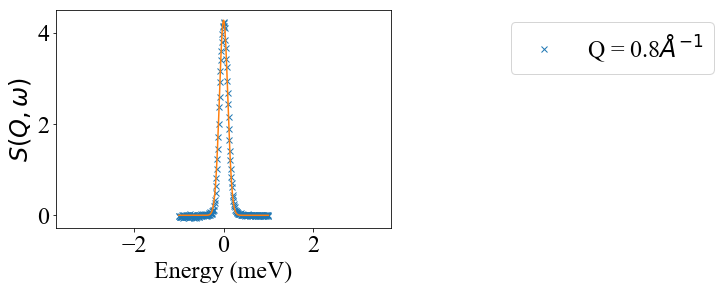

[0.09340911] [[9.75731915e-08]] 0.09193130005837381 0.00025980787211924144


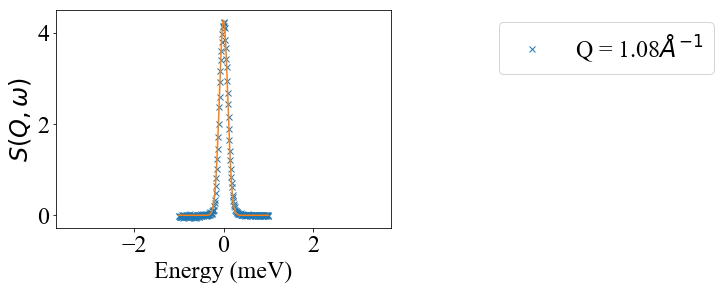

[0.09340911] [[9.75731915e-08]] 0.09193130005837381 0.00025980787211924144


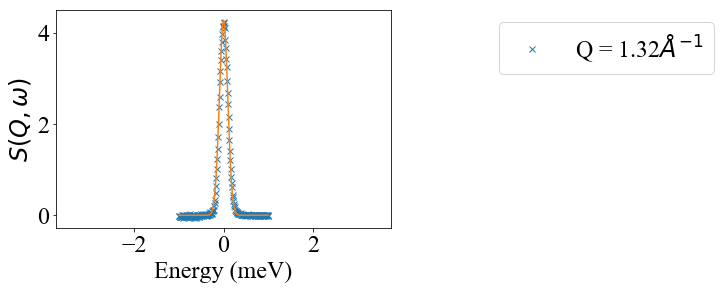

[0.09340911] [[9.75731915e-08]] 0.09193130005837381 0.00025980787211924144


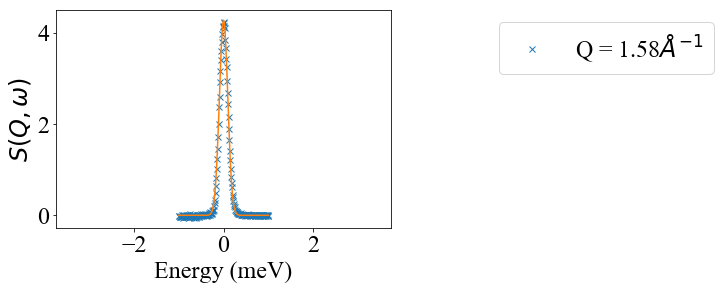

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 400.

In [24]:
def gaussian(x,sig):
    return (2*np.pi*sig**2)**(-0.5)*np.exp(-x**2/(2*sig**2))

for i in range(0,Q.shape[0]):
    popt, pcov = curve_fit(gaussian,energy,sqw_res_normalised[i,:],p0=[0.02])
    print popt, pcov, widths_res[i], widths_res_err[i]
    sig_res[i] = popt

    #fit the resolution data to a gaussian
    font = {'family' : 'times new roman',
            'weight' : 'normal',
            'size'   : 24}

    plt.rc('font', **font)
    plt.xlabel('Energy (meV)')
    plt.xlim(-40*popt[0],40*popt[0])
    plt.ylabel('$S(Q,\omega)$')
    plt.plot(energy,sqw_res_normalised[i,:],'x',label='Q = '+str(Q[i])+'$ \\AA^{-1}$')
    plt.plot(energy,gaussian(energy,popt[0]))
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()


### Testing the padded resolution function - after padding it on both sides with values from the fit.

806


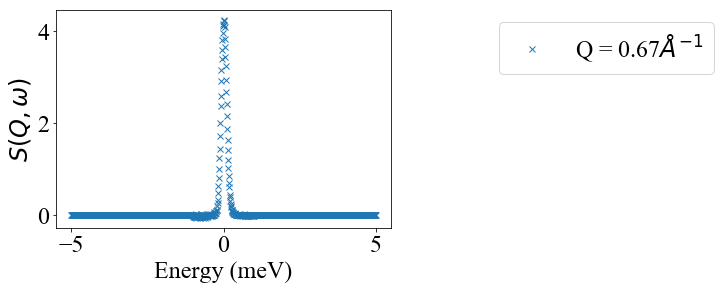

806


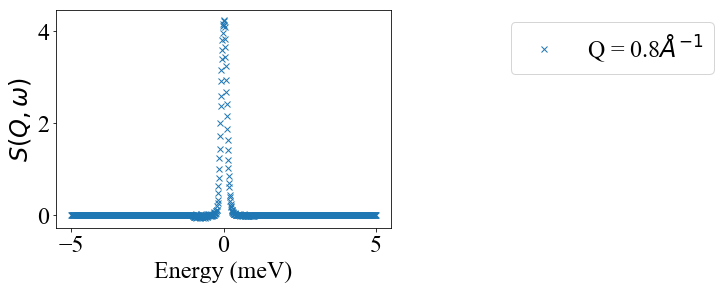

806


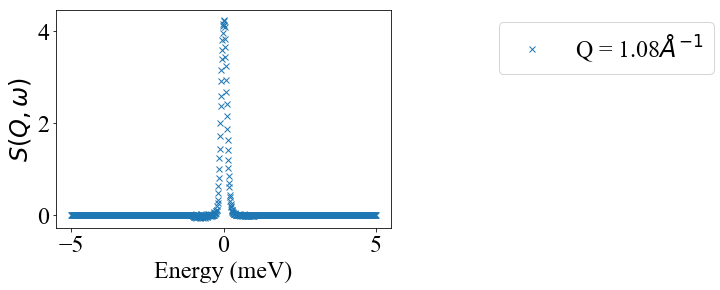

806


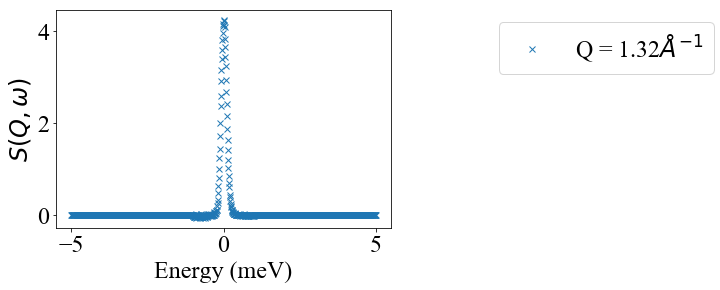

806


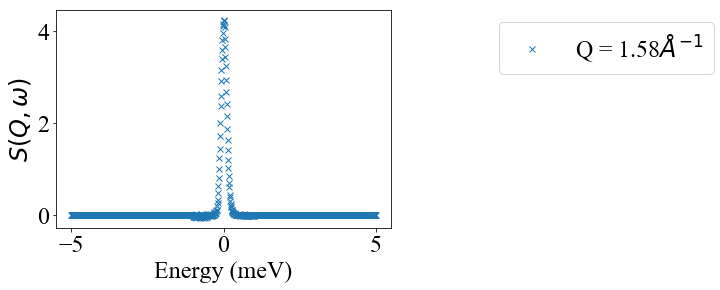

In [28]:
for i in range(0,Q.shape[0]-1):
    energy_extended = np.arange(-5.,5.+delE,delE)

    #padding it with data points from the fit with sig_res
    neg_en = np.arange(-5.,-1,delE)
    neg_pad = gaussian(neg_en,sig_res[i])
    pos_en = np.arange(1.+delE,5+delE,delE)
    pos_pad = gaussian(pos_en,sig_res[i])

    print neg_pad.shape[0]+sqw_res_normalised.shape[0]+pos_pad.shape[0]

    sqw_res_extended = np.concatenate((neg_pad,sqw_res_normalised[i,],pos_pad))

    plt.rc('font', **font)
    plt.xlabel('Energy (meV)')
    plt.yscale('linear')
    plt.ylabel('$S(Q,\omega)$')
    plt.plot(energy_extended,sqw_res_extended,'x',label='Q = '+str(Q[i])+'$ \\AA^{-1}$')
    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

In [29]:
w = False
if (w):
    folder = 'Reduced_data_100_hyd'
    chk = os.path.isdir(folder)
    if (not chk):
        os.mkdir(folder)
    for i in range(0,Q.shape[0]):
        fname = '/Q='+str(Q[i])
        write_to_file(energy,sqw[i,:],folder+fname)

wr = False
if (wr):
    folder = 'Reduced_res'
    chk = os.path.isdir(folder)
    if (not chk):
        os.mkdir(folder)
    for i in range(0,Q.shape[0]):
        fname = '/Q='+str(Q[i])
        write_to_file(energy,sqw_res[i,:],folder+fname)

### Mirror the data if required 

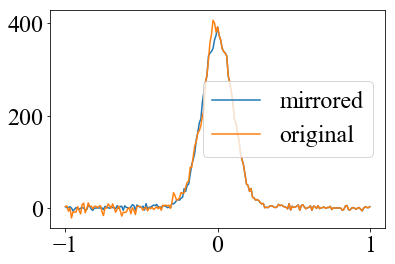

In [30]:
def mirror(ene,sqw_data,flag):
    dele = ene[0]-ene[1]
    zero_ene = np.amin(ene)
    zero_posn = np.argmin(abs(ene))
    if (flag == 1): #choose the positive side and reflect to the negative side
        sqw_data_pos = sqw_data[zero_posn+1:]
#         print ene[zero_posn+1:]
        sqw_data_neg = np.flip(sqw_data_pos)
        zero_ele = sqw_data[zero_posn:zero_posn+1]
        new_sqw = np.concatenate((sqw_data_neg,zero_ele,sqw_data_pos))
        return new_sqw
    elif (flag == -1): #choose the negative side and reflect to positive side
        sqw_data_neg = sqw_data[:zero_posn]
        print ene[:zero_posn]
        sqw_data_pos = np.flip(sqw_data_neg)
        zero_ele = sqw_data[zero_posn:zero_posn+1]
        new_sqw = np.concatenate((sqw_data_neg,zero_ele,sqw_data_pos))
        return new_sqw
    elif (flag == 0): #keep the data as such, don't change anything
        return sqw_data
    else:
        print "Wrong flag! Kindly choose values among -1,0 and 1. Returning 0!"
        return 0

test = mirror(energy,sqw[0],1)
test.shape, sqw[0].shape
plt.plot(energy,test,label='mirrored')
plt.plot(energy,sqw[0],label='original')
plt.legend()

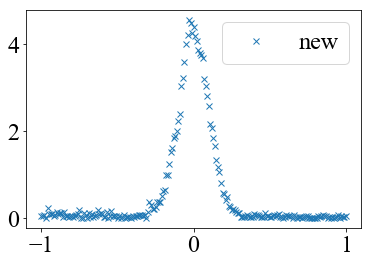

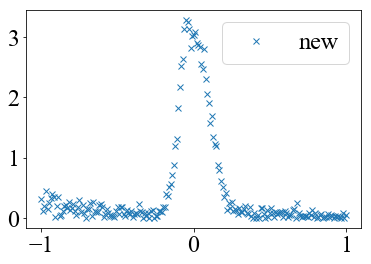

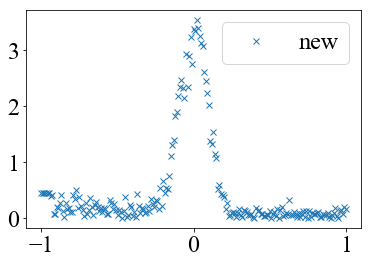

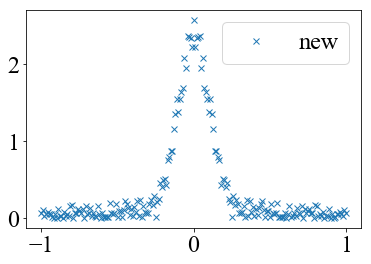

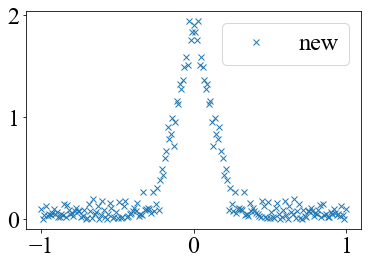

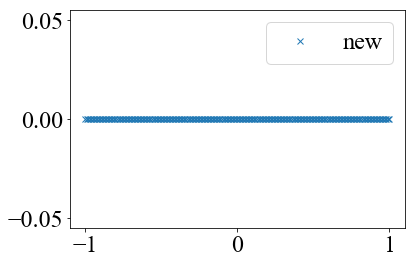

In [31]:
flip = np.zeros((Q.shape[0]),dtype='int')

flip = [0,0,0,1,1,1]
sqw_new = np.zeros((sqw.shape),dtype='float')
for i in range(Q.shape[0]):
    sqw_new[i,:] = mirror(energy,sqw_normalised[i,:],flip[i])
    sqw_new[i,:] = np.abs(sqw_new[i,:])
#     plt.plot(energy,sqw[i,:],'x',label='old')
    plt.plot(energy,sqw_new[i,:],'x',label='new')
    plt.legend()
    plt.show()

Fitting a theoretical model function $S_{th}(Q,\omega)$ with a resolution function a given $Q$-value.
$$
S_{expt} (Q,\omega) = S_{th}(Q,\omega) \otimes R(Q,\omega)
$$
But before convolution, the data and the resolution functions have to be area normalised.

### Defining a normalised Lorentzian of the form

$$
L(\Gamma,x) = \frac{1}{\pi}\frac{\Gamma(Q)}{\Gamma(Q)^2 + x^2}
$$

Here, $\Gamma(Q)$ is the half-width at half maximum (HWHM)

In [32]:
def lorentzian(x,hwhm):
    return (1/np.pi)*(hwhm)/(x**2 + (hwhm)**2)

### Defining a single Lorentzian function convoluted with resolution at a given Q

$$
S_{expt} (Q,\omega) = L(\Gamma,\omega) \otimes R(Q,\omega)
$$

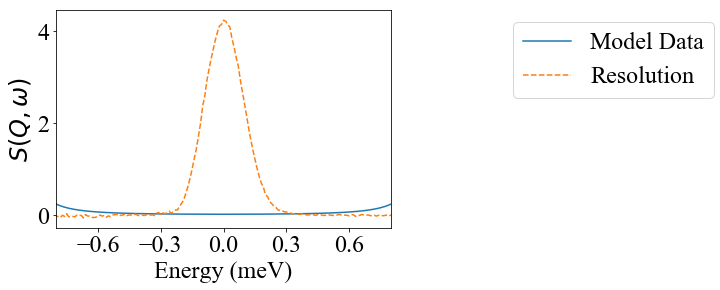

In [33]:
#qi is the q-index
def one_lor(x,hwhm,qi):
    #generate energy axis
    tmp_en = np.arange(-5,5+delE,delE)
    
    #generate resolution from gaussian and numerical function
    neg_en = np.arange(-5.,-1,delE)
    neg_pad = gaussian(neg_en,sig_res[i])
    pos_en = np.arange(1.+delE,5+delE,delE)
    pos_pad = gaussian(pos_en,sig_res[i])
#     print neg_pad
#     print pos_pad
    
    model_res = np.concatenate((neg_pad,sqw_res_normalised[i],pos_pad))
#     plt.xlim(-.5,0.5)
#     plt.plot(tmp_en,model_res)
    model_lor = lorentzian(tmp_en,hwhm)
#     plt.plot(tmp_en,model_lor)
    plt.show()
    tmp_convoluted = np.convolve(model_res,model_lor,'same')*delE
    ret = np.interp(x,tmp_en,tmp_convoluted)
    
    return ret

#testing the above defined function
gam = 0.05 #in meV
qindex = 1
sqw_test = one_lor(energy,gam,qindex)
plt.ylabel("$S(Q,\omega)$")
plt.xlabel("Energy (meV)") 

#peak normalise and plot
factor = np.max(sqw_res_normalised[qindex,:])/np.max(sqw_test)
sqw_test = sqw_test*factor
plt.xlim(-0.8,0.8)
plt.xticks((-0.6,-0.3,0.0,0.3,0.6))

plt.plot(energy,sqw_test,label='Model Data')
plt.plot(energy,sqw_res_normalised[qindex,:],label='Resolution',ls='--')
plt.legend(bbox_to_anchor=(2,1))
plt.show()

### Defining a Elastic + Lorentzian function convoluted with resolution at a given Q

$$
S_{expt} (Q,\omega) = \bigg[A_0(Q) + \big(1-A_0(Q)\big)L(\Gamma,\omega) \bigg] \otimes R(Q,\omega)
$$

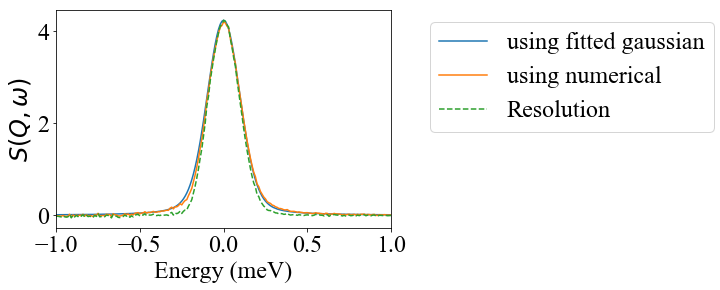

In [34]:
#fitting with one lorentzian and one delta
#qi - is the index for q-value
def del_lor(x,a,hwhm1,qi,key):
    #generate energy axis
    tmp_en = np.arange(-5,5+delE,delE)
    #generate resolution from gaussian
    
    #generate resolution from gaussian and numerical function
    if (key > 0):
        neg_en = np.arange(-5.,-1,delE)
        neg_pad = gaussian(neg_en,sig_res[qi])
        pos_en = np.arange(1.+delE,5+delE,delE)
        pos_pad = gaussian(pos_en,sig_res[qi])
        model_res = np.concatenate((neg_pad,sqw_res_normalised[qi],pos_pad))
    else:
        model_res = gaussian(tmp_en,sig_res[qi])
    model_fn = lorentzian(tmp_en,hwhm1)
    tmp_convoluted = np.convolve(model_res,model_fn,'same')*delE
    tmp_fn = a*model_res + (1-a)*tmp_convoluted
    ret = np.interp(x,tmp_en,tmp_fn)
    return ret

#testing the above defined function
gam = 0.1 #in meV
a0 = 0.7
qindex = 1
sqw_test = del_lor(energy,a0,gam,qindex,0)
sqw_test2 = del_lor(energy,a0,gam,qindex,1)
plt.ylabel("$S(Q,\omega)$")
plt.xlabel("Energy (meV)") 

#peak normalise and plot
factor = np.max(sqw_res_normalised[qindex,:])/np.max(sqw_test)
sqw_test = sqw_test*factor
sqw_test2 = sqw_test2*factor
plt.xlim(-1,1)

plt.plot(energy,sqw_test,label='using fitted gaussian')
plt.plot(energy,sqw_test2,label='using numerical')
plt.plot(energy,sqw_res_normalised[qindex,:],label='Resolution',ls='--')
plt.legend(bbox_to_anchor=(2,1))
plt.show()

### Defining a two Lorentzian functions convoluted with resolution at a given Q

$$
S_{expt} (Q,\omega) = \bigg[A_0(Q)L(\Gamma_1,\omega) + \big(1-A_0(Q)\big)L(\Gamma_2,\omega) \bigg] \otimes R(Q,\omega)
$$

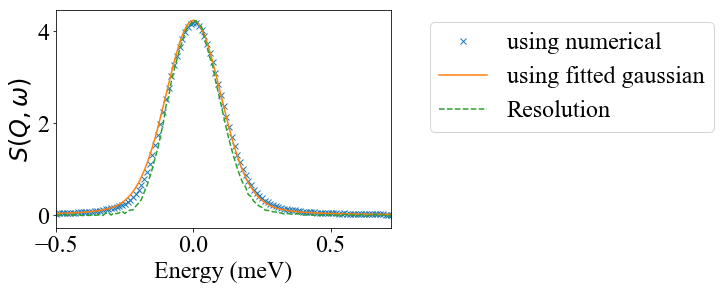

(6, 201)


In [35]:
#fitting with two lorentzians
def two_lor(x,a,hwhm1,hwhm2,qi,key):
    #generate energy axis
    tmp_en = np.arange(-5,5+delE,delE)
    #generate resolution from gaussian
    if (key > 0):
        neg_en = np.arange(-5.,-1,delE)
        neg_pad = gaussian(neg_en,sig_res[qi])
        pos_en = np.arange(1.+delE,5.+delE,delE)
        pos_pad = gaussian(pos_en,sig_res[qi])
        model_res = np.concatenate((neg_pad,sqw_res_normalised[qi],pos_pad))
    else:
        model_res = gaussian(tmp_en,sig_res[qi])
    
    model_fn = a*lorentzian(tmp_en,hwhm1) + (1-a)*lorentzian(tmp_en,hwhm2)
    tmp_convoluted = np.convolve(model_res,model_fn,'same')*delE
    ret = np.interp(x,tmp_en,tmp_convoluted)
    return ret

#testing the above defined function
gam1 = 0.01 #in meV
gam2 = 0.06
a0 = 0.73
qindex = 1
sqw_test = two_lor(energy,a0,gam1,gam2,qindex,0)
sqw_test2 = two_lor(energy,a0,gam1,gam2,qindex,1)
plt.ylabel("$S(Q,\omega)$")
plt.xlabel("Energy (meV)")

#peak normalise and plot
factor = np.max(sqw_res_normalised[qindex,:])/np.max(sqw_test)
sqw_test = sqw_test*factor
sqw_test2 = sqw_test2*factor
plt.xlim(-0.5,0.72)

plt.plot(energy,sqw_test2,'x',label='using numerical')
plt.plot(energy,sqw_test,label='using fitted gaussian')
plt.plot(energy,sqw_res_normalised[qindex,:],label='Resolution',ls='--')
plt.legend(bbox_to_anchor=(2,1))
plt.show()
print sqw_normalised.shape

### Fitting with a single Lorentzian

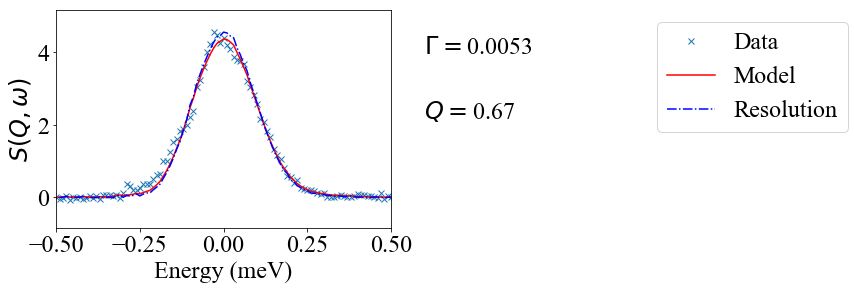

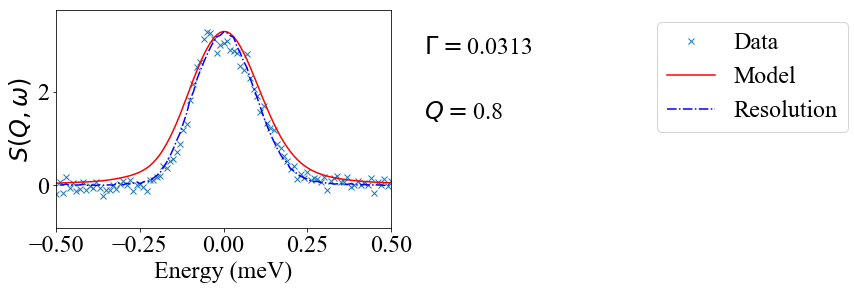

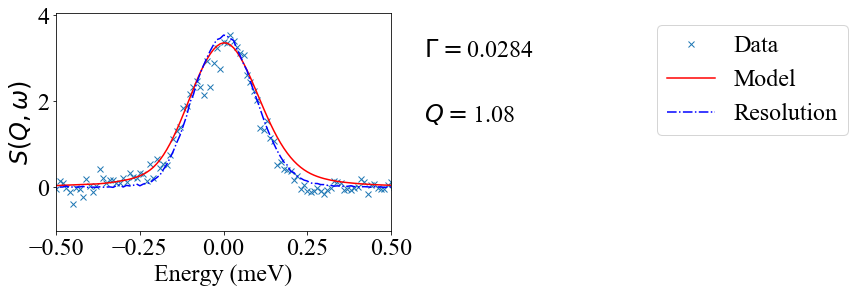

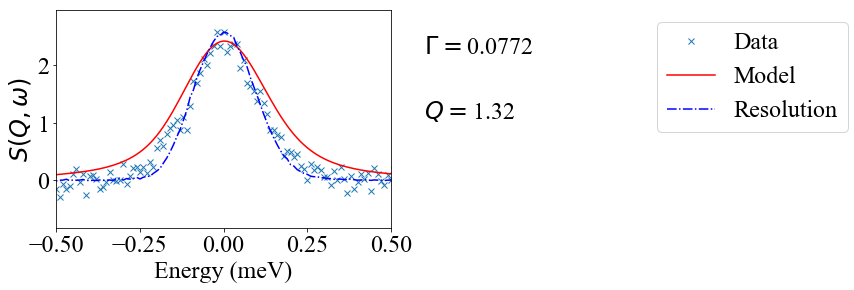

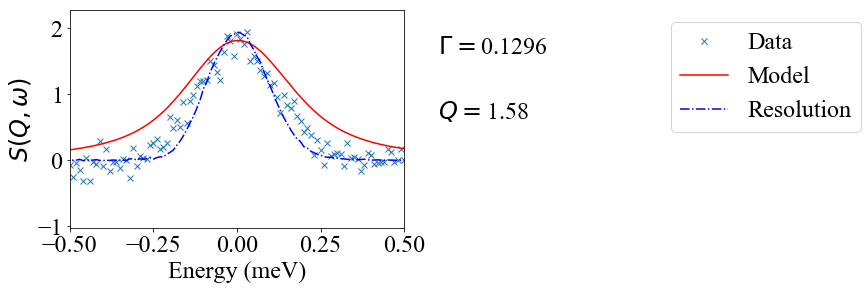

In [36]:
#fitting with single lorentzian
hwhm = np.empty((Q.shape[0]),dtype='float64')

for i in range(0,Q.shape[0]-1):
    ymax = np.max(sqw_normalised[i,:])
    ymin = np.min(sqw_normalised[i,:])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    yposn = ymax - dely
    
    
    popt, pcov = curve_fit(lambda x,gam: one_lor(x,gam,i),energy,sqw_normalised[i,:],p0=[0.5])
    
    hwhm[i] = popt[0]
    
    sqw_model = one_lor(energy,hwhm[i],i)
    
    plt.ylabel("$S(Q,\omega)$")
    plt.xlabel("Energy (meV)")
    plt.xlim(-0.5,0.5)
    plt.ylim(ymin-dely,ymax+dely)
    
    #factor calculation to plot resolution as peak normalised to data
    factor = np.max(sqw_normalised[i,:])/np.max(sqw_res_normalised[i,:])
    plt.plot(energy,sqw_normalised[i],'x',label='Data')
    plt.plot(energy,sqw_model,label='Model',color='red')
    #plt.plot(energy,lorentzian(energy,hwhm[i]),label='Lorentzian',color='green',ls='--')
    plt.plot(energy,factor*sqw_res_normalised[i,:],label='Resolution',color='blue',ls='-.')
    plt.text(0.6,yposn,"$\Gamma =$"+str( round(hwhm[i],4) ))
    plt.text(0.6,yposn-3*dely,"$Q =$"+str( round(Q[i],4) ))
    plt.legend(bbox_to_anchor=(2.4,1))
    plt.show()

#### Plotting HWHM to see how it fares!

(6,)


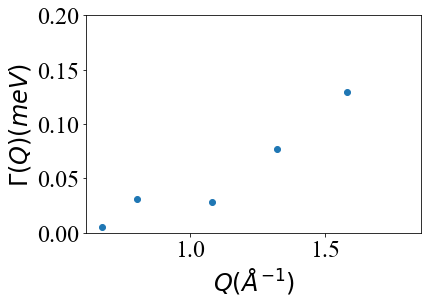

In [37]:
print hwhm.shape
plt.plot(Q,hwhm,'o')
plt.xlabel('$Q (\\AA^{-1})$')
plt.ylabel('$\Gamma(Q) (meV)$')
plt.ylim(0,0.2)
plt.show()

### Fitting with lorentzian and elastic line

$$
S_{expt} (Q,\omega) = \bigg[A_0(Q) + \big(1-A_0(Q)\big)L(\Gamma,\omega) \bigg] \otimes R(Q,\omega)
$$

0.9 0.94 0.92
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5067e+00                                    2.74e-01    
       1              2         1.3322e+00      1.74e-01       5.63e-02       6.38e-02    
       2              3         1.2999e+00      3.24e-02       2.11e-02       1.32e-02    
       3              4         1.2936e+00      6.25e-03       8.64e-03       2.85e-03    
       4              5         1.2918e+00      1.77e-03       3.79e-03       1.27e-03    
       5              6         1.2903e+00      1.51e-03       1.87e-03       1.05e-03    
       6              7         1.2894e+00      9.53e-04       1.29e-02       5.72e-04    
       7              8         1.2892e+00      1.52e-04       9.79e-03       1.35e-04    
       8              9         1.2892e+00      2.41e-05       4.39e-03       2.72e-05    
       9             10         1.2892e+00      1.98e-06       1.47e-03     

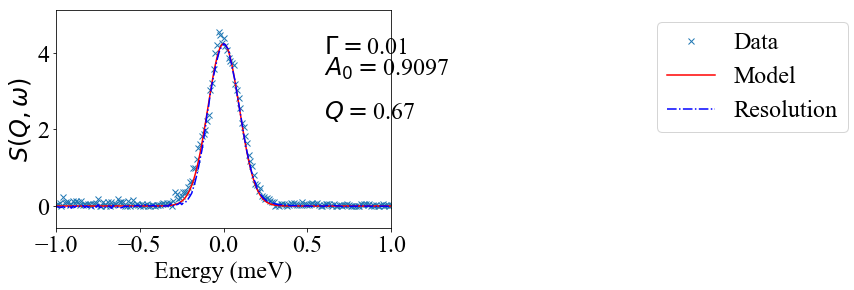

0.85 0.9 0.88
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.3555e+00                                    7.76e+00    
       1              2         5.6311e+00      2.72e+00       2.26e-01       8.70e-01    
       2              3         4.7004e+00      9.31e-01       1.49e-01       7.01e-02    
       3              4         4.5696e+00      1.31e-01       2.54e-02       1.65e-03    
       4              5         4.5665e+00      3.08e-03       6.10e-04       9.44e-07    
       5              6         4.5665e+00      1.76e-06       3.47e-07       3.07e-13    
`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 8.3555e+00, final cost 4.5665e+00, first-order optimality 3.07e-13.


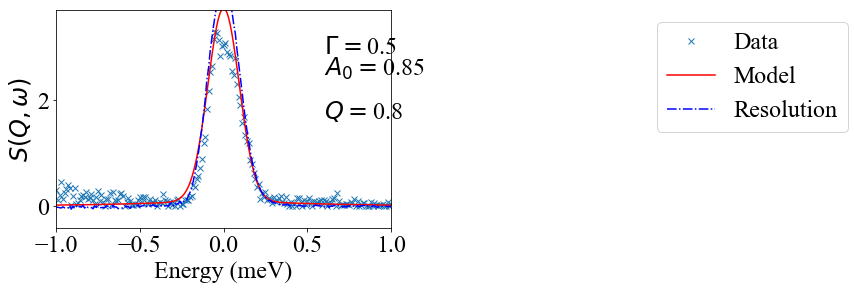

0.7 0.8 0.75
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4709e+00                                    9.57e+00    
       1              2         3.8425e+00      1.63e+00       1.11e-01       2.18e+00    
       2              3         3.2504e+00      5.92e-01       1.12e-01       5.00e-01    
       3              4         3.0578e+00      1.93e-01       8.99e-02       1.10e-01    
       4              5         3.0012e+00      5.67e-02       5.73e-02       2.17e-02    
       5              6         2.9852e+00      1.59e-02       2.58e-02       2.61e-03    
       6              7         2.9828e+00      2.46e-03       4.63e-03       2.65e-04    
       7              8         2.9827e+00      7.89e-05       1.55e-04       8.29e-06    
       8              9         2.9827e+00      1.89e-07       1.43e-06       2.14e-08    
       9             10         2.9827e+00      1.08e-11       3.65e-09      

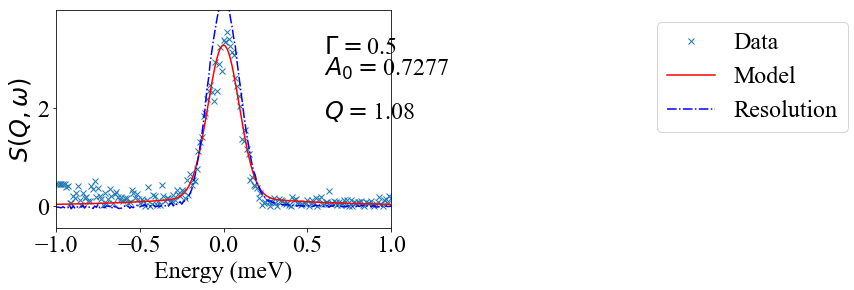

0.3 1.0 0.92
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3483e+01                                    3.14e+01    
       1              2         4.0367e+00      1.94e+01       3.67e-01       9.22e+00    
       2              3         1.4971e+00      2.54e+00       1.21e-01       2.11e+00    
       3              4         1.1385e+00      3.59e-01       5.93e-02       3.21e-01    
       4              5         1.0494e+00      8.92e-02       4.32e-02       6.35e-02    
       5              6         1.0198e+00      2.96e-02       1.82e-02       1.63e-02    
       6              7         1.0162e+00      3.61e-03       2.34e-03       1.49e-03    
       7              8         1.0161e+00      7.40e-05       5.54e-05       2.94e-05    
       8              9         1.0161e+00      8.14e-08       6.91e-07       3.20e-08    
       9             10         1.0161e+00      1.42e-12       7.61e-10      

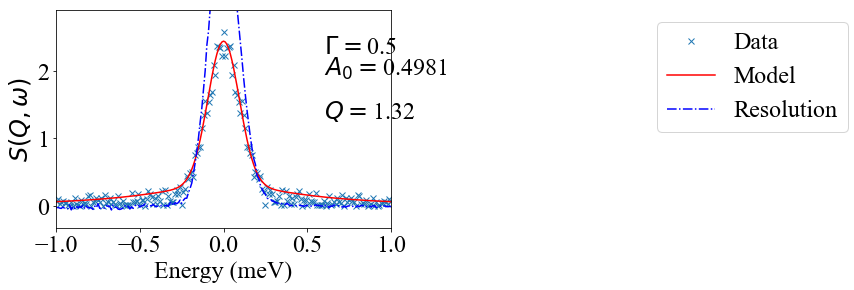

0.3 1.0 0.92
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0836e+01                                    4.15e+01    
       1              2         9.2832e+00      3.16e+01       4.18e-01       1.33e+01    
       2              3         3.5284e+00      5.75e+00       1.49e-01       3.52e+00    
       3              4         2.1873e+00      1.34e+00       7.45e-02       8.82e-01    
       4              5         1.9017e+00      2.86e-01       3.60e-02       1.94e-01    
       5              6         1.8480e+00      5.37e-02       1.43e-02       2.82e-02    
       6              7         1.8401e+00      7.83e-03       3.02e-03       1.52e-03    
       7              8         1.8398e+00      3.50e-04       1.61e-04       3.11e-05    
       8              9         1.8398e+00      9.39e-07       2.77e-06       7.67e-08    
       9             10         1.8398e+00      4.43e-11       6.96e-09      

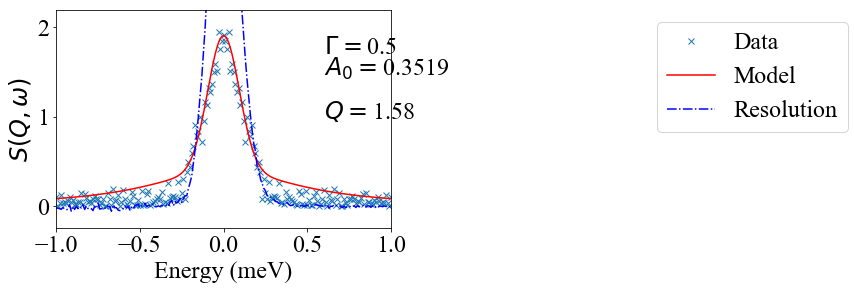

In [38]:
hwhm = np.empty((Q.shape[0]),dtype='float64')
a = np.empty((Q.shape[0]),dtype='float64')

a_l = np.empty((Q.shape[0]),dtype='float64')
a_u = np.empty((Q.shape[0]),dtype='float64')

hwhm.fill(0.1)
a.fill(0.92)
a_l.fill(0.3)
a_u.fill(1.0)

a[1] = 0.88
a[2] = 0.75

a_l[0] = 0.9
a_u[0] = 0.94

a_l[1] = 0.85
a_u[1] = 0.9

a_l[2] = 0.7
a_u[2] = 0.8

for i in range(0,Q.shape[0]-1):
    ymax = np.max(sqw_new[i,:])
    ymin = np.min(sqw_new[i,:])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    yposn = ymax - dely
    
    hwhm_u = 0.5
    hwhm_l = 0.01
    
    print a_l[i],a_u[i],a[i]
    popt, pcov = curve_fit(lambda x,a0,gam: del_lor(x,a0,gam,i,0),energy,sqw_new[i,:],
                           p0=[a[i],hwhm[i]],bounds=([a_l[i],hwhm_l],[a_u[i],hwhm_u]),verbose=2)
    
    a[i] = popt[0]
    hwhm[i] = popt[1]
    
    sqw_model = del_lor(energy,a[i],hwhm[i],i,0)
    
    plt.ylabel("$S(Q,\omega)$")
    plt.xlabel("Energy (meV)")
    plt.xlim(-1,1)
    plt.ylim(ymin-dely,ymax+dely)
    
    #factor calculation to plot resolution as peak normalised to data
    factor = np.max(sqw_new[i,:])/np.max(sqw_new[i,:])
    
    plt.plot(energy,sqw_new[i],'x',label='Data')
    plt.plot(energy,sqw_model,label='Model',color='red')
    #plt.plot(energy,lorentzian(energy,hwhm[i]),label='Lorentzian',color='green',ls='--')
    plt.plot(energy,factor*sqw_res_normalised[i,:],label='Resolution',color='blue',ls='-.')
    plt.text(0.6,yposn,"$\Gamma =$"+str( round(hwhm[i],4) ))
    plt.text(0.6,yposn-dely,"$A_0 =$"+str( round(a[i],4) ))
    plt.text(0.6,yposn-3*dely,"$Q =$"+str( round(Q[i],4) ))
    plt.legend(bbox_to_anchor=(2.4,1))
    plt.show()


(6,)


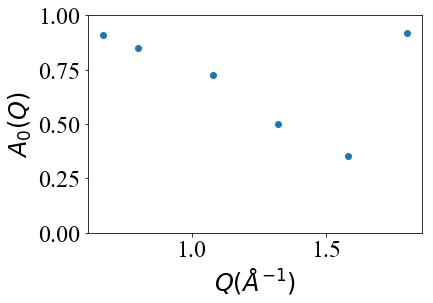

In [39]:
#### Plotting HWHM to see how it fares!

print hwhm.shape
plt.plot(Q,a,'o')
plt.xlabel('$Q (\\AA^{-1})$')
plt.ylabel('$A_0(Q)$')
plt.ylim(0,1)
plt.show()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3719e+00                                    1.46e+03    
       1              2         8.7147e-01      5.00e-01       9.10e-02       6.71e+01    
       2              3         8.1943e-01      5.20e-02       3.43e-02       1.91e+01    
       3              4         8.1109e-01      8.34e-03       7.26e-03       1.19e+00    
       4              5         8.1084e-01      2.51e-04       2.53e-04       3.15e-02    
       5              6         8.1084e-01      1.56e-06       2.18e-06       2.98e-04    
       6              7         8.1084e-01      7.86e-09       1.55e-08       3.83e-06    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.3719e+00, final cost 8.1084e-01, first-order optimality 3.83e-06.


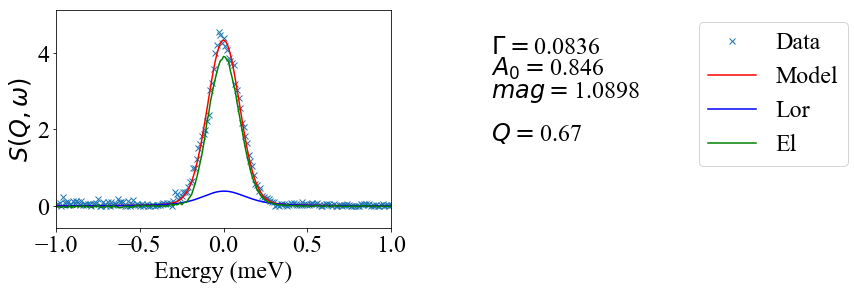

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.2514e+00                                    6.20e+01    
       1              2         2.6589e+00      6.59e+00       1.76e-01       9.13e+00    
       2              3         2.4384e+00      2.20e-01       3.67e-02       3.97e-01    
       3              4         2.4355e+00      2.89e-03       4.33e-03       3.35e-01    
       4              5         2.4348e+00      7.56e-04       2.44e-03       2.26e-01    
       5              6         2.4348e+00      2.30e-05       7.34e-04       5.74e-03    
       6              7         2.4348e+00      1.35e-07       2.63e-05       1.91e-05    
       7              8         2.4348e+00      3.12e-11       1.39e-07       3.07e-07    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 9.2514e+00, final cost 2.4348e+00, first-order optimality 3.07e-07.


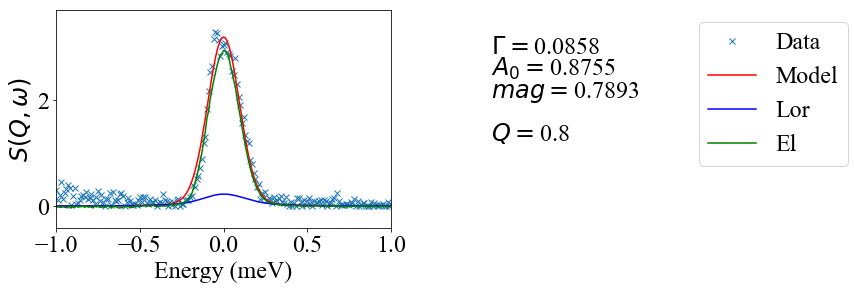

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.3511e+00                                    4.48e+01    
       1              2         3.6717e+00      3.68e+00       1.37e-01       5.43e+00    
       2              3         3.5689e+00      1.03e-01       2.55e-02       7.04e-02    
       3              4         3.5383e+00      3.06e-02       3.08e-02       1.23e+01    
       4              5         3.5288e+00      9.52e-03       1.56e-02       2.52e+00    
       5              6         3.5267e+00      2.02e-03       4.78e-03       3.13e-01    
       6              7         3.5265e+00      2.33e-04       6.22e-04       2.78e-02    
       7              8         3.5265e+00      4.02e-06       1.13e-05       6.00e-04    
       8              9         3.5265e+00      2.06e-08       6.80e-08       4.91e-06    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 7.3511e+00

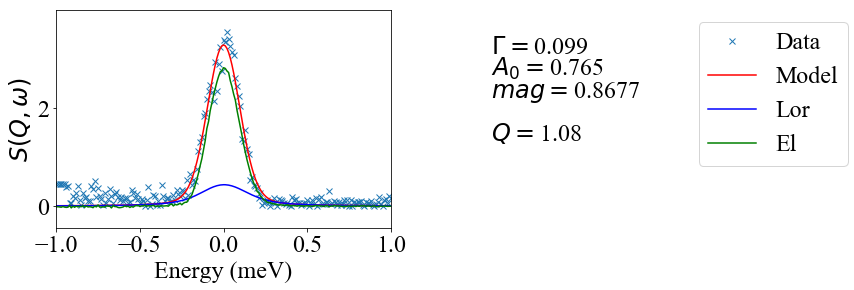

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3284e+01                                    7.59e+01    
       1              2         1.5406e+00      1.17e+01       2.39e-01       1.40e+01    
       2              3         7.7198e-01      7.69e-01       6.94e-02       1.19e+00    
       3              4         7.3009e-01      4.19e-02       2.26e-02       8.28e+00    
       4              5         7.0955e-01      2.05e-02       1.71e-02       5.59e+00    
       5              6         7.0623e-01      3.32e-03       3.31e-03       5.53e-01    
       6              7         7.0617e-01      6.30e-05       8.14e-05       1.29e-02    
       7              8         7.0617e-01      3.68e-07       8.47e-07       1.15e-04    
       8              9         7.0617e-01      1.85e-09       6.54e-09       2.43e-06    
Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 9, initi

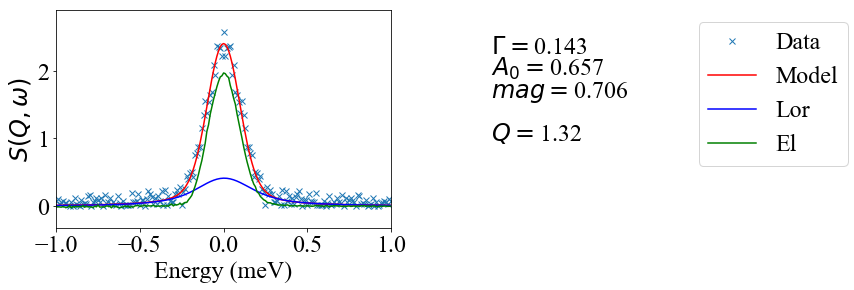

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7784e+01                                    8.08e+01    
       1              2         2.3224e+00      1.55e+01       2.84e-01       1.67e+01    
       2              3         8.8189e-01      1.44e+00       1.01e-01       2.08e+00    
       3              4         8.2851e-01      5.34e-02       1.86e-02       2.65e-02    
       4              5         8.0958e-01      1.89e-02       1.62e-02       5.33e+00    
       5              6         8.0579e-01      3.78e-03       4.47e-03       7.53e-01    
       6              7         8.0566e-01      1.37e-04       2.33e-04       3.10e-02    
       7              8         8.0566e-01      1.27e-06       2.85e-06       3.77e-04    
       8              9         8.0566e-01      6.85e-09       2.68e-08       1.14e-06    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 1.7784e+01

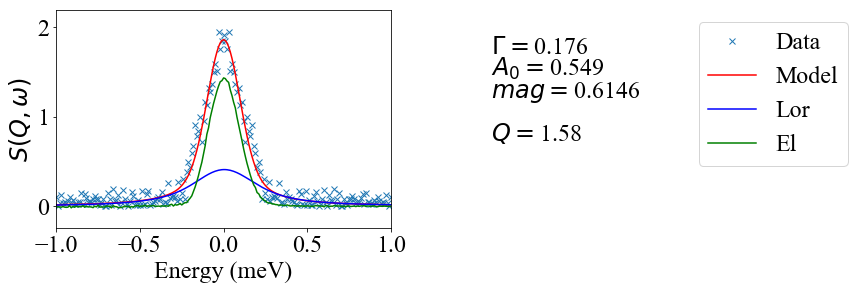

In [120]:
hwhm = np.array([0.076,0.078,0.09,0.13,0.16,0.19])
a = np.array([0.94,0.90,0.85,0.73,0.61,0.53])

sqw_model = np.zeros((sqw_normalised.shape),dtype='float')
sqw_lor = np.zeros((sqw_normalised.shape),dtype='float')
sqw_el = np.zeros((sqw_normalised.shape),dtype='float')

hwhm_err = np.array([0.06,0.08,0.09,0.11,0.14,0.16])
a_err = np.array([0.99,0.85,0.85,0.73,0.61,0.53])

da = 0.1
a_l = (1.-da)*a
a_u = (1.+da)*a

dg = 0.1
hwhm_l = (1.-dg)*hwhm
hwhm_u = (1.+dg)*hwhm


for i in range(0,Q.shape[0]-1):
    ymax = np.max(sqw_new[i,:])
    ymin = np.min(sqw_new[i,:])
    ydiff = (ymax - ymin)
    dely = ydiff/8.
    yposn = ymax - dely
    
    popt, pcov = curve_fit(lambda x,a0,gam,mag: mag*del_lor(x,a0,gam,i,0),energy,sqw_new[i,:],
                           p0=[a[i],hwhm[i],1.0],bounds=([a_l[i],hwhm_l[i],0.0],[a_u[i],hwhm_u[i],100]),verbose=2)
    
    a[i] = popt[0]
    hwhm[i] = popt[1]
    mag = popt[2]
    
    a_err[i] = np.sqrt(pcov[0,0])
    hwhm_err[i] = np.sqrt(pcov[1,1])
    
    sqw_model[i,:] = mag*del_lor(energy,a[i],hwhm[i],i,0)
    sqw_lor[i,:] = mag*(1-a[i])*one_lor(energy,hwhm[i],i)
    sqw_el[i,:]  = mag*a[i]*sqw_res_normalised[i,:]
    
    plt.ylabel("$S(Q,\omega)$")
    plt.xlabel("Energy (meV)")
    plt.xlim(-1,1)
    plt.ylim(ymin-dely,ymax+dely)
    
    #factor calculation to plot resolution as peak normalised to data
    factor = np.max(sqw_new[i,:])/np.max(sqw_res_normalised[i,:])
    
    plt.plot(energy,sqw_new[i],'x',label='Data')
    plt.plot(energy,sqw_model[i],label='Model',color='red')
    plt.plot(energy,sqw_lor[i],label='Lor',color='blue')
    plt.plot(energy,sqw_el[i],label='El',color='green')
    #plt.plot(energy,lorentzian(energy,hwhm[i]),label='Lorentzian',color='green',ls='--')
#     plt.plot(energy,factor*sqw_res_normalised[i,:],label='Resolution',color='blue',ls='-.')
    plt.text(1.6,yposn,"$\Gamma =$"+str( round(hwhm[i],4) ))
    plt.text(1.6,yposn-dely,"$A_0 =$"+str( round(a[i],4) ))
    plt.text(1.6,yposn-2*dely,"$mag =$"+str( round(mag,4) ))
    plt.text(1.6,yposn-4*dely,"$Q =$"+str( round(Q[i],4) ))
    plt.legend(bbox_to_anchor=(2.4,1))
    plt.show()


In [127]:
write_to_file(np.round(energy,3),np.round(sqw_res_normalised,6),'Res.dat')
s_data = sqw_new[3]
s_fit = sqw_model[3]
s_lor = sqw_lor[3]
s_el = sqw_el[3]
s_write = np.transpose(np.column_stack((s_data,s_fit,s_lor,s_el)))
write_to_file(np.round(energy,3),np.round(s_write,6),"Data_Q=1p32.dat")

In [128]:
print Q[3]

1.32


In [136]:
np.random.seed(200)
hwhm_err = hwhm*0.2*np.random.rand()

(6,)


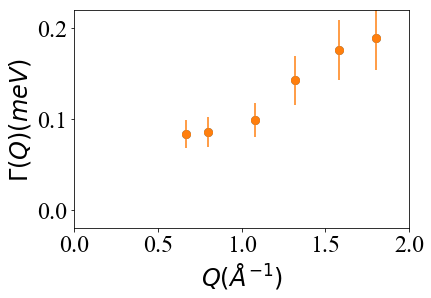

0.67 0.084
0.8 0.086
1.08 0.099
1.32 0.143
1.58 0.176
1.8 0.19


In [137]:
print hwhm.shape
plt.plot(Q,hwhm,'o',ms=8)
plt.errorbar(Q,hwhm,hwhm_err,fmt='o',ms=8)
plt.xlabel('$Q (\\AA^{-1})$')
plt.ylabel('$\Gamma(Q) (meV)$')
plt.ylim(-0.02,0.22)
plt.xlim(0,2)
plt.show()

for i in range(Q.shape[0]):
    print Q[i],round(hwhm[i],3)

In [138]:
h_w = np.transpose(np.column_stack((hwhm,hwhm_err)))
write_to_file(Q,h_w,'HWHM.dat')

In [130]:
a_err[-1]=0.1

(6,)


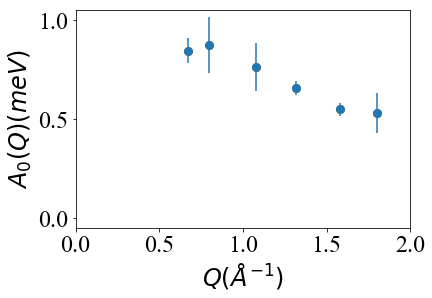

0.67 0.846
0.8 0.875
1.08 0.765
1.32 0.657
1.58 0.549
1.8 0.53


In [67]:
print hwhm.shape
plt.errorbar(Q,a,a_err,fmt='o',ms=8)
plt.plot(Q,a,'o',ms=8)
plt.xlabel('$Q (\\AA^{-1})$')
plt.ylabel('$A_0(Q) (meV)$')
plt.ylim(-0.05,1.05)
plt.xlim(0,2)
plt.show()

for i in range(Q.shape[0]):
    print Q[i],round(a[i],3)

In [131]:
a_w = np.transpose(np.column_stack((a,a_err)))
write_to_file(Q,a_w,'EISF.dat')

### Fitting all the EISF with the following model

### Modelling $A_0(Q)$ with confined diffusion model based on exponential distribution on $r$
$$
A_0(Q) = p_x + (1-p_x) \bigg[\frac{3j_1(Qr_i)}{Qr_i}\bigg]^2
$$

In [133]:
def eisf2(x,r,px):
    
    sp = spherical_jn(1,x*r)
    s = px + (1-px)*(3*sp/(x*r))**2

    return s

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0170e-02                                    1.89e-01    
       1              2         1.2338e-02      1.78e-02       8.13e-02       2.57e-02    
       2              3         1.1682e-02      6.56e-04       1.68e-02       3.27e-03    
       3              4         1.1639e-02      4.27e-05       2.69e-03       1.54e-04    
       4              5         1.1639e-02      2.53e-08       9.93e-05       1.13e-07    
       5              6         1.1639e-02      7.09e-12       7.26e-08       1.18e-10    
`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 3.0170e-02, final cost 1.1639e-02, first-order optimality 1.18e-10.


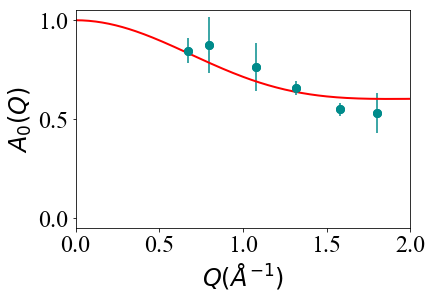

2.4000000000000004 0.6018902594525877


In [134]:
Qcont = np.arange(1e-8,10.0,0.01)


opt, cov = curve_fit(eisf2,Q,a,
                     p0=[2.41,0.7],bounds=([2.4,0.2],[2.43,1.0]),verbose=2)
r = opt[0]
px = opt[1]
r_err = np.sqrt(cov[0,0])
px_err = np.sqrt(cov[1,1])
eisf_model = eisf2(Qcont,r,px)
plt.xlim(0,2.0)
plt.ylim(-.05,1.05)
plt.xlabel("$Q (\\AA^{-1})$")
plt.ylabel("$A_0(Q)$")
plt.plot(Q,a,'o',ms=8,color='darkcyan',label='Expt.')
plt.errorbar(Q,a,a_err,fmt='o',color='darkcyan',ms=8)
plt.plot(Qcont,eisf_model,linewidth=2,color='red',label='Fit')
plt.show()
print r,px

In [135]:
write_to_file(Qcont,eisf_model,'EISF_model.dat')

In [96]:
f = open('volino','r')
lines = f.readlines()
xnl = np.zeros([25,9])
for lin in lines:
    l = int(float(lin.split(' ')[0]))
    n = int(float(lin.split(' ')[1]))
    tmp = float(lin.split(' ')[2])
    xnl[l,n] = tmp
for n in range(0,9):
    for l in range(0,25):
        print l,n,xnl[l,n]

0 0 0.0
1 0 2.081576
2 0 3.342094
3 0 4.5141
4 0 5.646704
5 0 6.756456
6 0 7.851078
7 0 8.934839
8 0 10.010371
9 0 11.079418
10 0 12.143204
11 0 13.20262
12 0 14.258341
13 0 15.310887
14 0 16.360674
15 0 17.408034
16 0 18.453241
17 0 19.496524
18 0 20.538074
19 0 21.578053
20 0 22.616601
21 0 23.653839
22 0 24.689873
23 0 25.724794
24 0 26.758685
0 1 4.493409
1 1 5.94037
2 1 7.289932
3 1 8.583755
4 1 9.840446
5 1 11.070207
6 1 12.279334
7 1 13.47203
8 1 14.651263
9 1 15.819216
10 1 16.97755
11 1 18.127564
12 1 19.270294
13 1 20.406581
14 1 21.53712
15 1 22.616601
16 1 23.783192
17 1 24.899636
18 1 26.012188
19 1 0.0
20 1 0.0
21 1 0.0
22 1 0.0
23 1 0.0
24 1 0.0
0 2 7.725252
1 2 9.20584
2 2 10.613855
3 2 11.97273
4 2 13.295564
5 2 14.590552
6 2 15.863222
7 2 17.117506
8 2 18.356318
9 2 19.581889
10 2 20.795967
11 2 21.999955
12 2 23.194996
13 2 24.382038
14 2 25.561873
15 2 26.735177
16 2 0.0
17 2 0.0
18 2 0.0
19 2 0.0
20 2 0.0
21 2 0.0
22 2 0.0
23 2 0.0
24 2 0.0
0 3 10.904122
1 3 12.404

In [97]:
import scipy.special as spl
def sphbess(lp,zp):
    ret = np.sqrt( np.pi/(2*zp) ) * spl.jv(lp+0.5,zp)
    return ret
    

def anl(z,n,l,xnl):
    if (abs(z**2 - xnl**2) < 1e-6):
        ret = (3./2.) * sphbess(l,z)**2 * ( z**2 - l*(l+1) )/( z**2 )
    else:
        term1 = ( 6*xnl**2 )/( xnl**2 - l*(l+1) )
        term2 = ( z*sphbess(l+1,z) - l*sphbess(l,z) )/( z**2 - xnl**2 )
        ret = term1*term2**2
    return ret

#### Calculation of $I(Q,t)$ with obtained values of $A_n^l(Q)$, $D_i$, $R_i$ and $x_n^l$. Make it an array in t, calculate it for a given and given carbon atom (implicit).

Calculation is for a given $R_i$, $D_i$ and Q. <br>
The functions returns a numpy array which is a function '$t$'.
$$
I(Q,t) = \sum_{{l,n}}(2l+1) A_n^l(QR_i)\exp\Bigg[-\frac{2{x_n^l}^2}{R_i^2}D_i t\Bigg]
$$


#### Inputs
$R, D, Q,$ Array of $x_n^l$
#### Output
Array of I(Q,t=array dimension)

In [98]:
def iqt(r,d,q,xnl,t):
#     t = np.arange(0,50.005,0.005)  #time array
    tot_iqt = np.zeros([t.shape[0]])
    for n in range(0,9):
        for l in range(0,25):
            if ( abs(xnl[l,n]) > 1e-4 ):
                anl_tmp = anl(q*r,n,l,xnl[l,n])
                exponent = (xnl[l,n]**2/r**2)*d
                exp_tmp = np.exp(-exponent*t)
                each_term = (2.*l+1.)*anl_tmp*exp_tmp
                tot_iqt = each_term + tot_iqt
                #print exponent.shape,exp_tmp.shape,each_term.shape,tot_iqt.shape
    return tot_iqt
t = np.arange(0,500.1,0.1)
iqt_c = iqt(6.0,0.19,2.0,xnl,t)

print iqt_c

[9.97574166e-01 9.26675205e-01 8.61376057e-01 ... 2.81108141e-09
 2.80466026e-09 2.79825378e-09]


#### Write a function where the free parameter is Q, and the return value is $\Gamma$ calculated from the $I(Q,t)$ obtained for this whole excercise - in this case, take a single diffusion coefficient, $D$ <br>

##### In the input of gamma function, take the distribution of r also, so that it's not calculated from a random distribution every time it is called by curve_fit

In [99]:
%matplotlib inline
from scipy.optimize import fsolve
def gamma(Q,d,r):
  
    
    #calculation of I(Q,t), call iqt(r[i],d[i],Q,xnl-array); xnl array is already read, just use it
    t = np.arange(0,500.1,0.1)
    iqt_each = np.zeros([Q.shape[0],t.shape[0]])

    for k in range(0,len(Q)):
        iqt_each[k,:] = iqt(r,d,Q[k],xnl,t)
        
    y = np.zeros([Q.shape[0],t.shape[0]])
    #normalise iqt_sum for each Q value
    for k in range(0,len(Q)):
        y[k,:] = iqt_each[k,:]/iqt_each[k,0]

    Gcal = np.zeros([len(Q)])
    #solve for which value of 't'  [iqt_sum(t) - 1/e] = 0 for each Q, store it in a gamma array
    
    
    for k in range(0,len(Q)):
        t_i = np.interp(np.exp(-1), y[k,::-1], t[::-1] )
        Gcal[k] = 1/t_i

    
    return Gcal

r = 1.4
test = gamma(Q,0.05,r)
print test


[0.11619667 0.11823562 0.1243317  0.13188317 0.14334332 0.15662745]


In [109]:
print r

2.4000000000000004


In [139]:
popt, pcov = curve_fit(lambda q,d: gamma(q,d,r),
                           Q,hwhm,sigma=hwhm_err,
                           p0=[0.08],
                           bounds=([0.01,1.0]),verbose=2)
print popt, pcov
dint = popt[0]
dint_e = np.sqrt(pcov[0,0])    
print dint/0.658

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1018e+00                                    2.11e+02    
       1              2         7.6857e-01      1.33e+00       1.15e-02       1.88e+00    
       2              3         7.6847e-01      1.01e-04       1.04e-04       1.72e-02    
       3              4         7.6847e-01      1.13e-06       1.07e-05       3.84e-04    
       4              5         7.6847e-01      4.51e-12       2.14e-08       6.25e-08    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.1018e+00, final cost 7.6847e-01, first-order optimality 6.25e-08.
[0.09163463] [[1.55760103e-05]]
0.1392623511751038


In [140]:
Qcont = np.arange(1e-8,2.2,0.1)
hwhm_model = gamma(Qcont,dint,r)
print r

2.4000000000000004


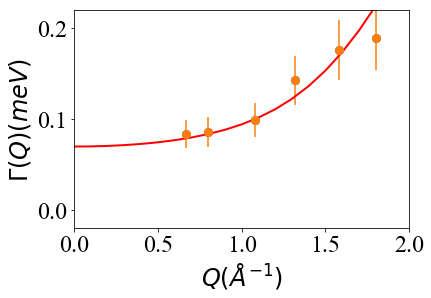

0.1392623511751038


In [141]:
plt.rc('font', **font)

plt.plot(Q,hwhm,'o',ms=8)
plt.errorbar(Q,hwhm,hwhm_err,fmt='o',ms=8)
plt.plot(Qcont,hwhm_model,lw=2,color='red')
plt.xlabel('$Q (\\AA^{-1})$')
plt.ylabel('$\Gamma(Q) (meV)$')
plt.ylim(-0.02,0.22)
plt.xlim(0,2)
plt.show()
print dint/0.658


In [142]:
write_to_file(Qcont,hwhm_model,'HWHM_model.dat')